In [2]:
import os
import time

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
import warnings

from utils.dataset import get_df, generate_column_names

warnings.filterwarnings("ignore")

In [ ]:
# df = pd.read_csv("data/processed_data.csv", parse_dates=["timestamp"], index_col="timestamp")

In [ ]:
# X = df.drop(columns=["y"])
# y = df["y"]

In [ ]:
# X_windowed = flatten_windowed_data(X, window_size=16)
# y_windowed = y[16 - 1 :]

In [ ]:
# from sklearn.model_selection import train_test_split

# X_temp, X_test, y_temp, y_test = train_test_split(
#     X_windowed, y_windowed, test_size=0.15, shuffle=False, random_state=42
# )
# X_train, X_val, y_train, y_val = train_test_split(
#     X_temp, y_temp, test_size=0.1765, shuffle=False, random_state=42
# )  # 0.1765 x 0.85 ≈ 0.15

In [16]:
# X_train.shape, X_val.shape, X_test.shape, X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

((9316, 896), (1997, 896), (1997, 896), 13310)

In [6]:
X_train_16, X_val_16, X_test_16, y_train_16, y_val_16, y_test_16 = get_df(window_size=16)
X_train_32, X_val_32, X_test_32, y_train_32, y_val_32, y_test_32 = get_df(window_size=32)
X_train_48, X_val_48, X_test_48, y_train_48, y_val_48, y_test_48 = get_df(window_size=48)

In [43]:
X_train_16.shape, X_train_32.shape, X_train_48.shape

((9320, 896), (9304, 1792), (9288, 2688))

In [44]:
X_val_16.shape, X_val_32.shape, X_val_48.shape

((2039, 896), (2039, 1792), (2039, 2688))

In [45]:
X_test_16.shape, X_test_32.shape, X_test_48.shape

((1951, 896), (1951, 1792), (1951, 2688))

In [46]:
X_val_48.shape

(2039, 2688)

In [47]:
X_train_16.shape, X_val_16.shape, X_test_16.shape, X_train_16.shape[0] + X_val_16.shape[0] + X_test_16.shape[0]

((9320, 896), (2039, 896), (1951, 896), 13310)

In [48]:
X_train_48.columns[:50]

Index(['nvda_open_t-0', 'nvda_high_t-0', 'nvda_low_t-0', 'nvda_close_t-0',
       'nvda_volume_t-0', 'amd_open_t-0', 'amd_high_t-0', 'amd_low_t-0',
       'amd_close_t-0', 'amd_volume_t-0', 'intc_open_t-0', 'intc_high_t-0',
       'intc_low_t-0', 'intc_close_t-0', 'intc_volume_t-0', 'spy_open_t-0',
       'spy_high_t-0', 'spy_low_t-0', 'spy_close_t-0', 'spy_volume_t-0',
       'dia_open_t-0', 'dia_high_t-0', 'dia_low_t-0', 'dia_close_t-0',
       'dia_volume_t-0', 'iwm_open_t-0', 'iwm_high_t-0', 'iwm_low_t-0',
       'iwm_close_t-0', 'iwm_volume_t-0',
       'insider_traded_shares_3d_shifted_t-0', 'btc_open_t-0', 'btc_high_t-0',
       'btc_low_t-0', 'btc_close_t-0', 'btc_volume_t-0', 'gold_open_t-0',
       'gold_high_t-0', 'gold_low_t-0', 'gold_close_t-0', 'gold_volume_t-0',
       'overall_sentiment_score_t-0', 'nvda_sentiment_score_t-0',
       'nvda_relevance_score_t-0', 'rsi_14_t-0', 'stoch_k_t-0', 'stoch_d_t-0',
       'macd_t-0', 'macd_signal_t-0', 'macd_hist_t-0'],
      dtype

In [7]:
PRICE_CLOSE_ONLY_COLS = ["nvda_close"]
PRICE_CLOSE_VOLUME_COLS = ["nvda_close", "nvda_volume"]
PRICE_OHLC_COLS = ["nvda_open", "nvda_high", "nvda_low", "nvda_close"]
PRICE_OHLCV_COLS = ["nvda_open", "nvda_high", "nvda_low", "nvda_close", "nvda_volume"]
COLS_GROUPS = {
    "price_close_only": PRICE_CLOSE_ONLY_COLS,
    "price_close_volume": PRICE_CLOSE_VOLUME_COLS,
    "price_ohlc": PRICE_OHLC_COLS,
    "price_ohlcv": PRICE_OHLCV_COLS,
}
WINDOW_SIZES_DATA_DATA = {
    16: (X_train_16, X_val_16, X_test_16, y_train_16, y_val_16, y_test_16),
    32: (X_train_32, X_val_32, X_test_32, y_train_32, y_val_32, y_test_32),
    48: (X_train_48, X_val_48, X_test_48, y_train_48, y_val_48, y_test_48),
}
MODELS = [
    "GaussianNB",
    "RandomForestClassifier",
    "XGBClassifier",
    "LGBMClassifier",
]


In [51]:
X_train_16[generate_column_names(["nvda_close", "nvda_volume"], window_size=16)].head()

,nvda_close_t-0,nvda_volume_t-0,nvda_close_t-1,nvda_volume_t-1,nvda_close_t-2,nvda_volume_t-2,nvda_close_t-3,nvda_volume_t-3,nvda_close_t-4,nvda_volume_t-4,...,nvda_close_t-11,nvda_volume_t-11,nvda_close_t-12,nvda_volume_t-12,nvda_close_t-13,nvda_volume_t-13,nvda_close_t-14,nvda_volume_t-14,nvda_close_t-15,nvda_volume_t-15
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-04 00:00:00+00:00,23.4690,1065750.0,23.7289,94800.0,23.6990,132890.0,23.6960,18208950.0,23.6740,44784510.0,...,24.2680,776990.0,24.0574,166470.0,23.9596,50490.0,23.9596,9530.0,23.9735,46180.0
2022-03-04 09:00:00+00:00,23.2308,192780.0,23.4690,1065750.0,23.7289,94800.0,23.6990,132890.0,23.6960,18208950.0,...,24.0364,32272410.0,24.2680,776990.0,24.0574,166470.0,23.9596,50490.0,23.9596,9530.0
2022-03-04 10:00:00+00:00,23.2907,26040.0,23.2308,192780.0,23.4690,1065750.0,23.7289,94800.0,23.6990,132890.0,...,23.5023,48024650.0,24.0364,32272410.0,24.2680,776990.0,24.0574,166470.0,23.9596,50490.0
2022-03-04 11:00:00+00:00,23.2837,99220.0,23.2907,26040.0,23.2308,192780.0,23.4690,1065750.0,23.7289,94800.0,...,23.9026,39162410.0,23.5023,48024650.0,24.0364,32272410.0,24.2680,776990.0,24.0574,166470.0
2022-03-04 12:00:00+00:00,23.2008,637530.0,23.2837,99220.0,23.2907,26040.0,23.2308,192780.0,23.4690,1065750.0,...,23.8775,36726510.0,23.9026,39162410.0,23.5023,48024650.0,24.0364,32272410.0,24.2680,776990.0


In [53]:
generate_column_names(["nvda_close", "nvda_volume"], window_size=4)

['nvda_close_t-0',
 'nvda_volume_t-0',
 'nvda_close_t-1',
 'nvda_volume_t-1',
 'nvda_close_t-2',
 'nvda_volume_t-2',
 'nvda_close_t-3',
 'nvda_volume_t-3']

In [54]:
pipelines = {}
metrics_val = {}
metrics_test = {}

for window_size in WINDOW_SIZES_DATA_DATA.keys():
    X_train, X_val, X_test, y_train, y_val, y_test = WINDOW_SIZES_DATA_DATA[window_size]
    for col_group_name, col_group in COLS_GROUPS.items():
        for model_name in MODELS:
            scaler = MinMaxScaler()
            if model_name == "GaussianNB":
                model = GaussianNB()
            elif model_name == "RandomForestClassifier":
                model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            elif model_name == "XGBClassifier":
                model = XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1)
            elif model_name == "LGBMClassifier":
                params = {
                    "objective": "binary",  # For binary classification
                    "metric": "binary_logloss",  # Evaluation metric
                    "boosting_type": "gbdt",
                    "num_leaves": 31,
                    "learning_rate": 0.05,
                    "feature_fraction": 0.9,
                    "verbose": -1,  # Suppress verbose output
                }
                model = LGBMClassifier(**params, random_state=42, n_jobs=-1)
            else:
                raise ValueError(f"Unknown model name: {model_name}")
            pipeline = Pipeline([("scaler", scaler), ("classifier", model)])
            col_to_use = generate_column_names(col_group, window_size)

            start_time = time.time()
            pipeline.fit(X_train[col_to_use], y_train)
            end_time = time.time()
            y_pred = pipeline.predict(X_val[col_to_use])
            y_pred_proba = pipeline.predict_proba(X_val[col_to_use])[:, 1]
            train_time = end_time - start_time

            report_dict = classification_report(
                y_val,
                y_pred,
                # 0 = Down, 1 = Up
                target_names=["Down", "Up"],
                zero_division=0,
                output_dict=True,
            )
            report = classification_report(
                y_val,
                y_pred,
                # 0 = Down, 1 = Up
                target_names=["Down", "Up"],
                zero_division=0,
                output_dict=False,
            )

            fpr, tpr, _ = roc_curve(
                y_val,
                y_pred_proba,
            )
            auc_score = auc(fpr, tpr)

            pipelines[(window_size, col_group_name, model_name)] = pipeline
            metrics_val[(window_size, col_group_name, model_name)] = {
                "time_used": train_time,
                "classification_report": report_dict,
                "classification_report_str": report,
                "roc_auc": {
                    "fpr": fpr.tolist(),
                    "tpr": tpr.tolist(),
                    "auc_score": auc_score,
                },
                "col_used": col_group,
            }
            print(
                f"Completed: Window Size={window_size}, Col Group={col_group_name}, Model={model_name} in {train_time:.2f} seconds"
            )

model_dir = "1_price_analysis"
os.makedirs(model_dir, exist_ok=True)
# Save eentire pipelines and metrics dictionaries
joblib.dump(pipelines, model_dir + "/pipelines.joblib")
joblib.dump(metrics_val, model_dir + "/metrics.joblib")

Completed: Window Size=16, Col Group=price_close_only, Model=GaussianNB in 0.01 seconds
Completed: Window Size=16, Col Group=price_close_only, Model=RandomForestClassifier in 0.74 seconds
Completed: Window Size=16, Col Group=price_close_only, Model=XGBClassifier in 0.22 seconds
Completed: Window Size=16, Col Group=price_close_only, Model=LGBMClassifier in 0.07 seconds
Completed: Window Size=16, Col Group=price_close_volume, Model=GaussianNB in 0.01 seconds
Completed: Window Size=16, Col Group=price_close_volume, Model=RandomForestClassifier in 0.50 seconds
Completed: Window Size=16, Col Group=price_close_volume, Model=XGBClassifier in 0.13 seconds
Completed: Window Size=16, Col Group=price_close_volume, Model=LGBMClassifier in 0.08 seconds
Completed: Window Size=16, Col Group=price_ohlc, Model=GaussianNB in 0.01 seconds
Completed: Window Size=16, Col Group=price_ohlc, Model=RandomForestClassifier in 1.38 seconds
Completed: Window Size=16, Col Group=price_ohlc, Model=XGBClassifier in 0.

['1_price_analysis/metrics.joblib']

In [55]:
len(pipelines)

48

In [3]:
pipelines_loaded = joblib.load("1_price_analysis/pipelines.joblib")
metrics_loaded = joblib.load("1_price_analysis/metrics.joblib")

In [9]:
for window_size in WINDOW_SIZES_DATA_DATA.keys():
    for col_group_name, col_group in list(COLS_GROUPS.items()):
        for model_name in MODELS:
            print("Window Size:", window_size, "Col Group:", col_group_name, "Model:", model_name)
            print(metrics_loaded[(window_size, col_group_name, model_name)]["classification_report_str"])

Window Size: 16 Col Group: price_close_only Model: GaussianNB
              precision    recall  f1-score   support

        Down       0.00      0.00      0.00      1106
          Up       0.46      1.00      0.63       933

    accuracy                           0.46      2039
   macro avg       0.23      0.50      0.31      2039
weighted avg       0.21      0.46      0.29      2039

Window Size: 16 Col Group: price_close_only Model: RandomForestClassifier
              precision    recall  f1-score   support

        Down       0.57      0.67      0.61      1106
          Up       0.50      0.39      0.44       933

    accuracy                           0.54      2039
   macro avg       0.53      0.53      0.53      2039
weighted avg       0.54      0.54      0.53      2039

Window Size: 16 Col Group: price_close_only Model: XGBClassifier
              precision    recall  f1-score   support

        Down       0.56      0.64      0.60      1106
          Up       0.49      0.40   

In [64]:
X_test_48.shape, y_val_48.shape

((1951, 2688), (2039,))

In [65]:
print(
    classification_report(
        y_test_16,
        pipelines[(16, "price_close_volume", "LGBMClassifier")].predict(
            X_test_16[generate_column_names(PRICE_CLOSE_VOLUME_COLS, 16)]
        ),
    )
)

              precision    recall  f1-score   support

           0       0.56      0.72      0.63      1054
           1       0.50      0.32      0.39       897

    accuracy                           0.54      1951
   macro avg       0.53      0.52      0.51      1951
weighted avg       0.53      0.54      0.52      1951



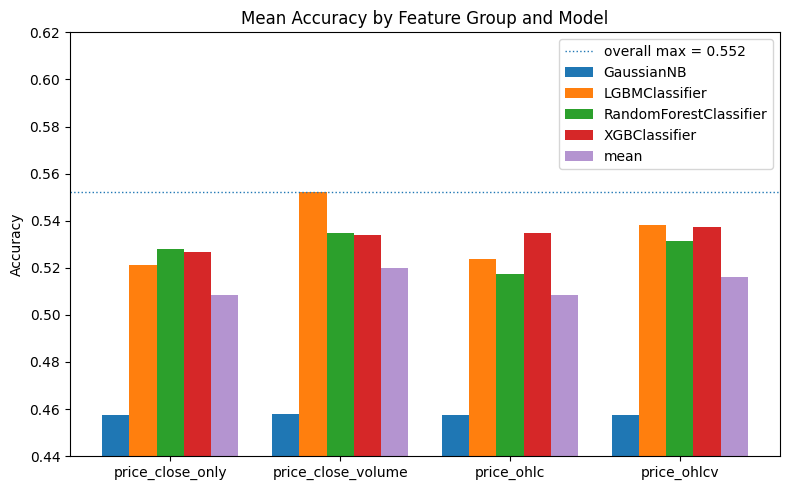

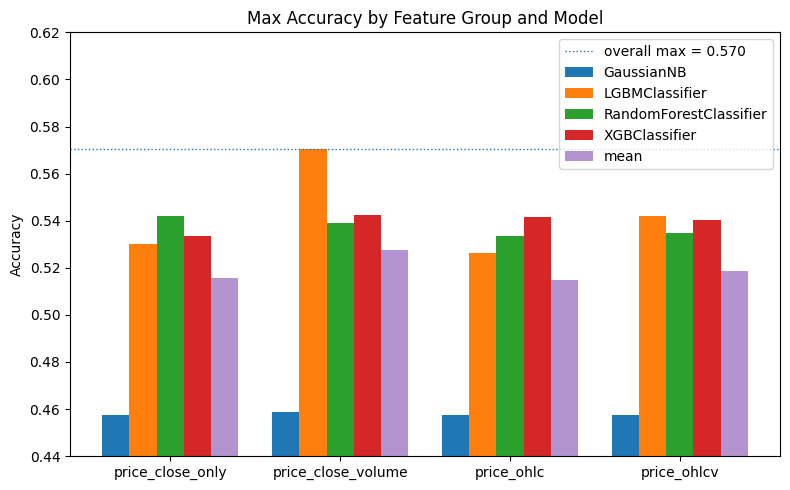

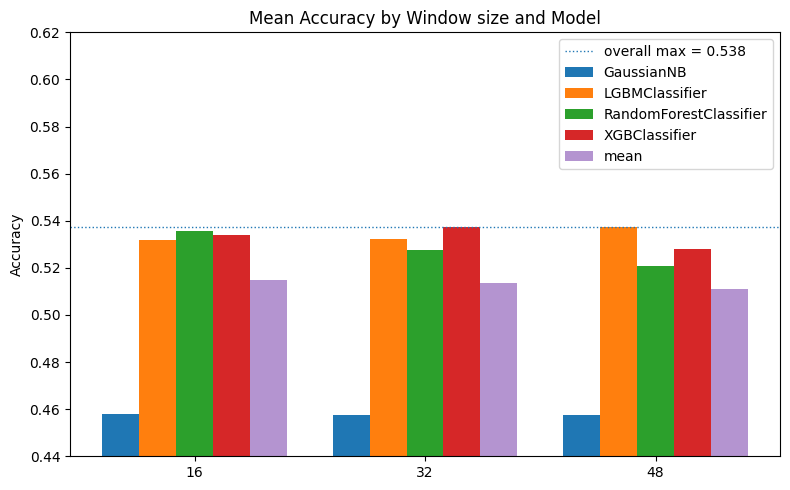

In [ ]:
# Build summary DataFrame
rows = []
for window_size in WINDOW_SIZES_DATA_DATA.keys():
    for col_group_name in COLS_GROUPS.keys():
        for model_name in MODELS:
            rep = metrics_loaded[(window_size, col_group_name, model_name)]["classification_report"]
            rows.append(
                {
                    "window": window_size,
                    "col_group": col_group_name,
                    "model": model_name,
                    "accuracy": float(rep["accuracy"]),
                }
            )
df = pd.DataFrame(rows)


def plot_grouped_bars(matrix: pd.DataFrame, title: str, ylabel: str = "Accuracy", show_mean_bar=True):
    groups = list(matrix.index)  # x-axis: feature groups
    models = list(matrix.columns)  # each model is a bar series
    vals = matrix.values
    n_groups, n_models = vals.shape

    # include one extra bar for group mean or max if requested
    total_bars = n_models + (1 if show_mean_bar else 0)
    x = np.arange(n_groups)
    width = 0.8 / total_bars
    center_shift = (total_bars - 1) * width / 2

    plt.figure(figsize=(max(8, 1.6 * n_groups), 5))

    # plot bars per model
    for j, model_name in enumerate(models):
        plt.bar(x + j * width - center_shift, vals[:, j], width, label=model_name)

    # plot mean or max across models per feature group
    if show_mean_bar:
        row_mean = vals.mean(axis=1)
        j_mean = n_models
        plt.bar(x + j_mean * width - center_shift, row_mean, width, label="mean", alpha=0.7)

    # lines for groupwise and overall maxima
    overall_max = float(vals.max())
    plt.axhline(overall_max, linestyle=":", linewidth=1, label=f"overall max = {overall_max:.3f}")

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(x, groups)
    plt.ylim(0.44, 0.62)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


# Compute mean accuracy by col_group and model
pivot_mean = df.pivot_table(index="col_group", columns="model", values="accuracy", aggfunc="mean").sort_index()
plot_grouped_bars(pivot_mean, title="Mean Accuracy by Feature Group and Model")

# Compute max accuracy by col_group and model
pivot_max = df.pivot_table(index="col_group", columns="model", values="accuracy", aggfunc="max").sort_index()
plot_grouped_bars(pivot_max, title="Max Accuracy by Feature Group and Model")

pivot_winsize = df.pivot_table(index="window", columns="model", values="accuracy", aggfunc="mean").sort_index()
plot_grouped_bars(pivot_winsize, title="Mean Accuracy by Window size and Model")

In [69]:
df

,window,col_group,model,accuracy
0,16,price_close_only,GaussianNB,0.457577
1,16,price_close_only,RandomForestClassifier,0.541932
2,16,price_close_only,XGBClassifier,0.533595
3,16,price_close_only,LGBMClassifier,0.517901
4,16,price_close_volume,GaussianNB,0.458558
5,16,price_close_volume,RandomForestClassifier,0.532614
6,16,price_close_volume,XGBClassifier,0.531143
7,16,price_close_volume,LGBMClassifier,0.546346
8,16,price_ohlc,GaussianNB,0.457577
9,16,price_ohlc,RandomForestClassifier,0.533595


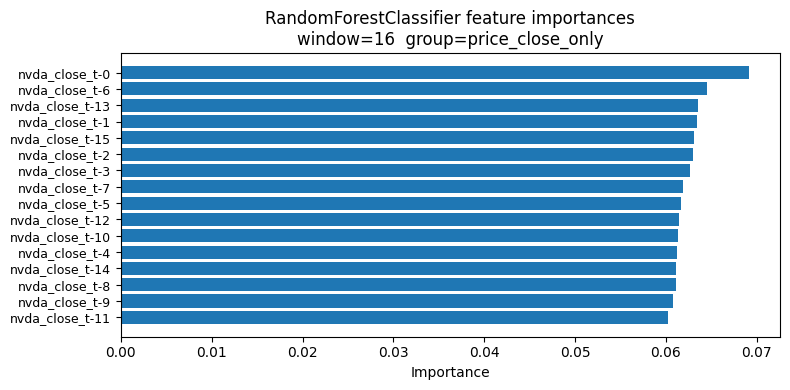

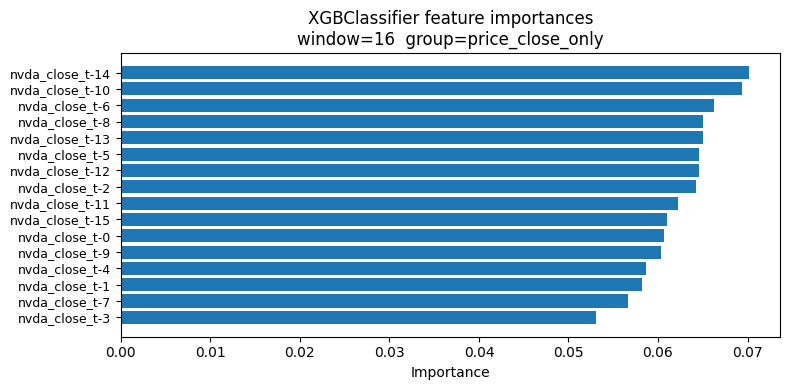

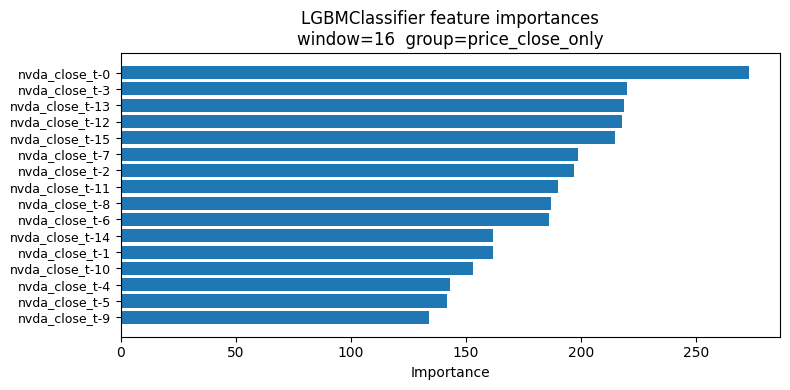

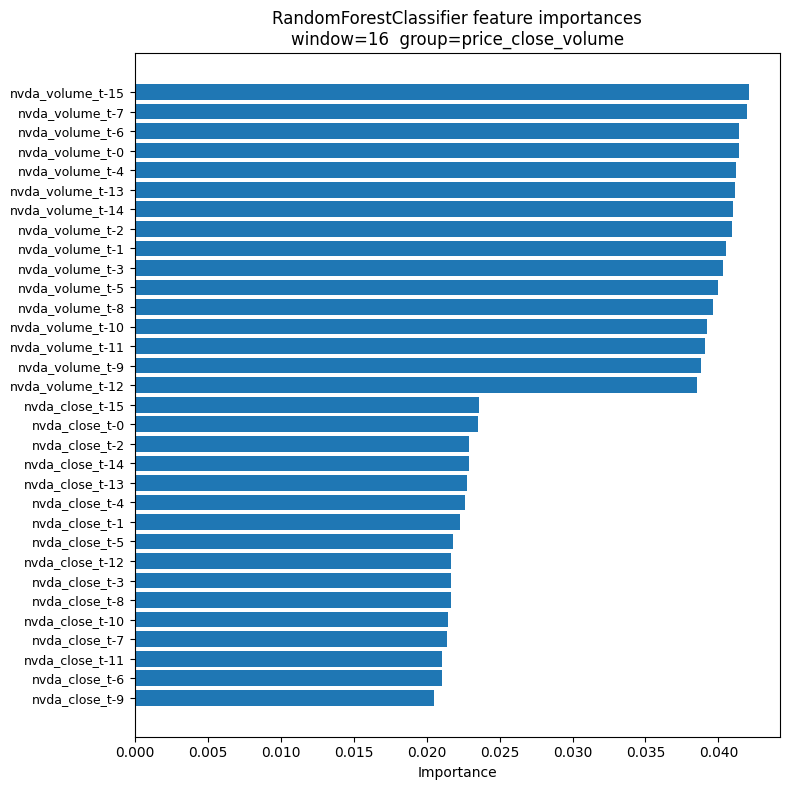

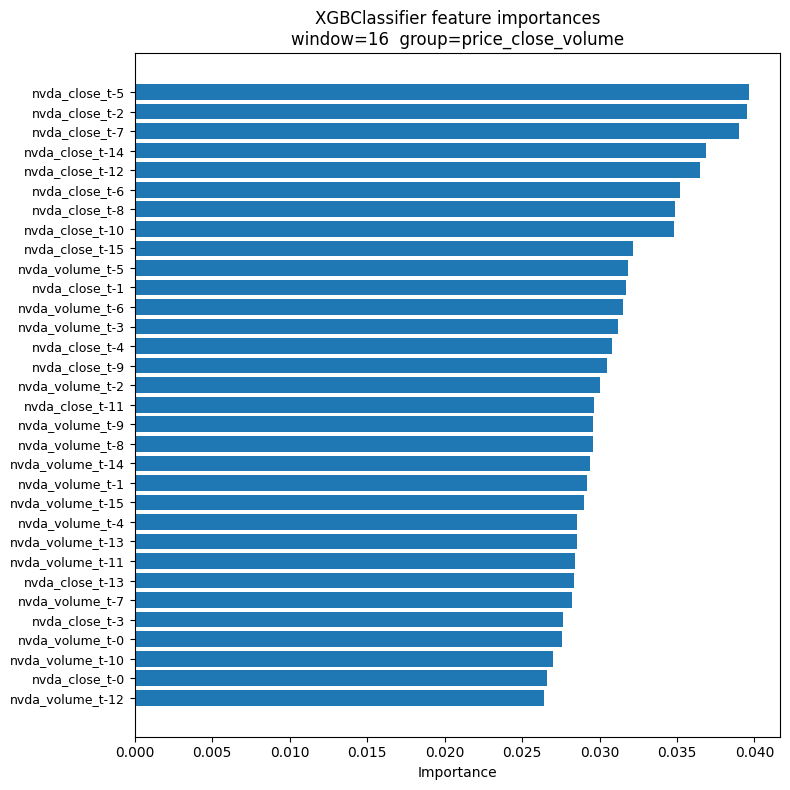

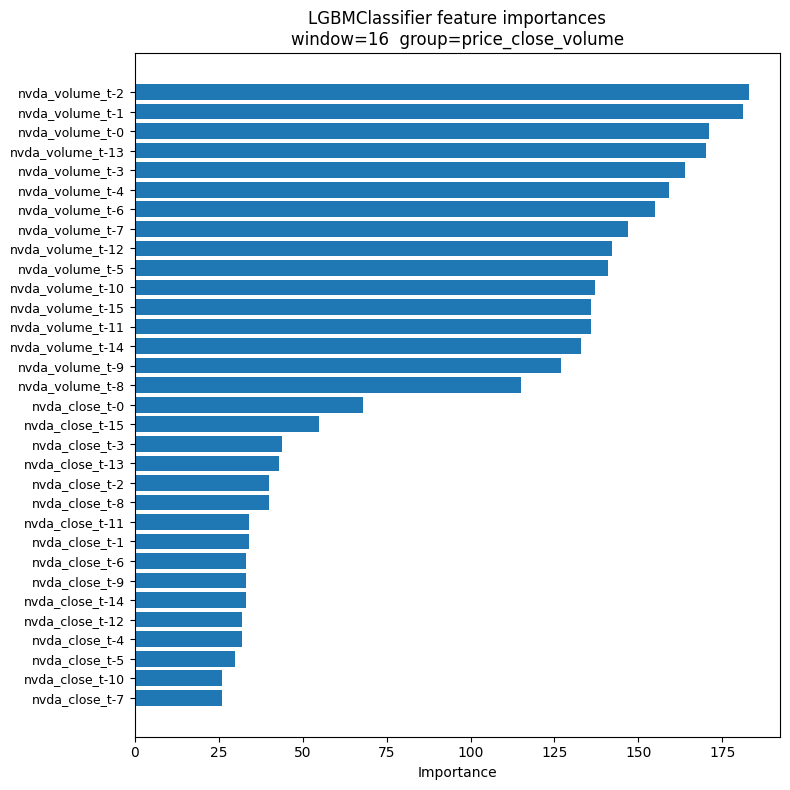

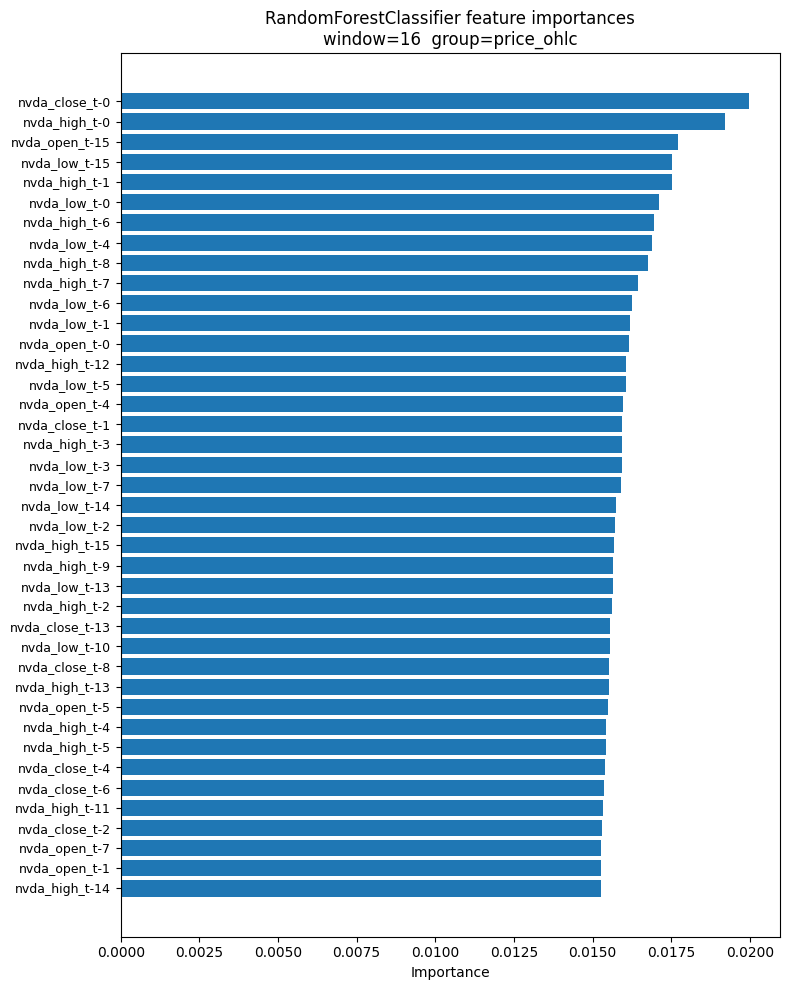

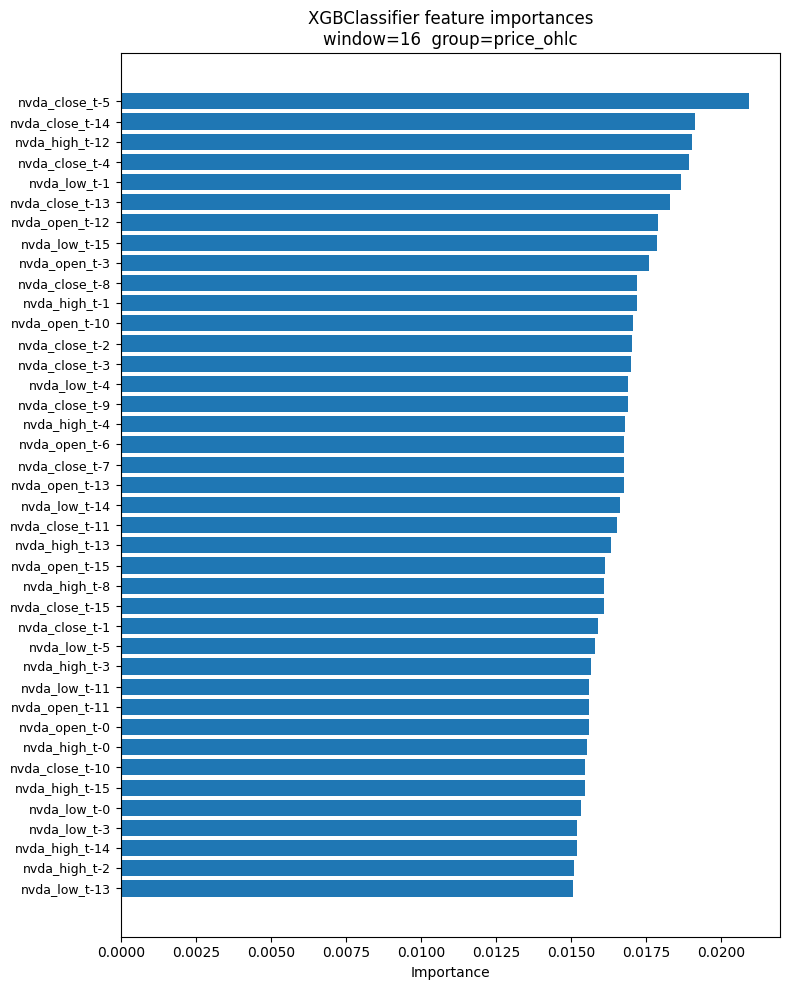

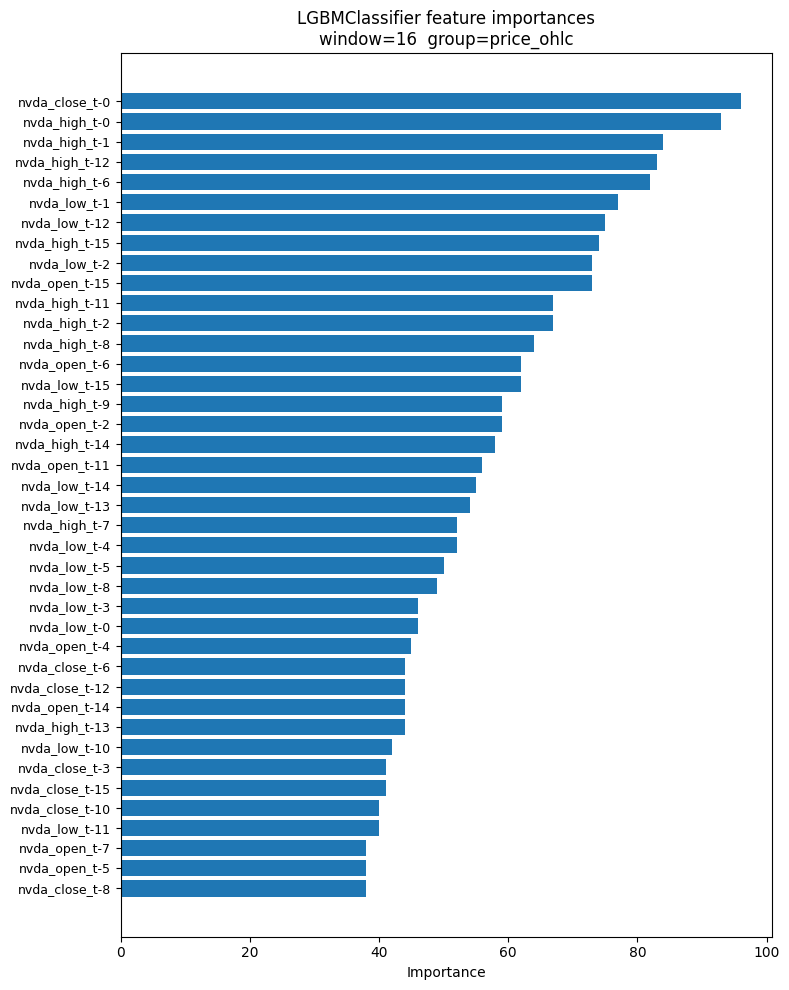

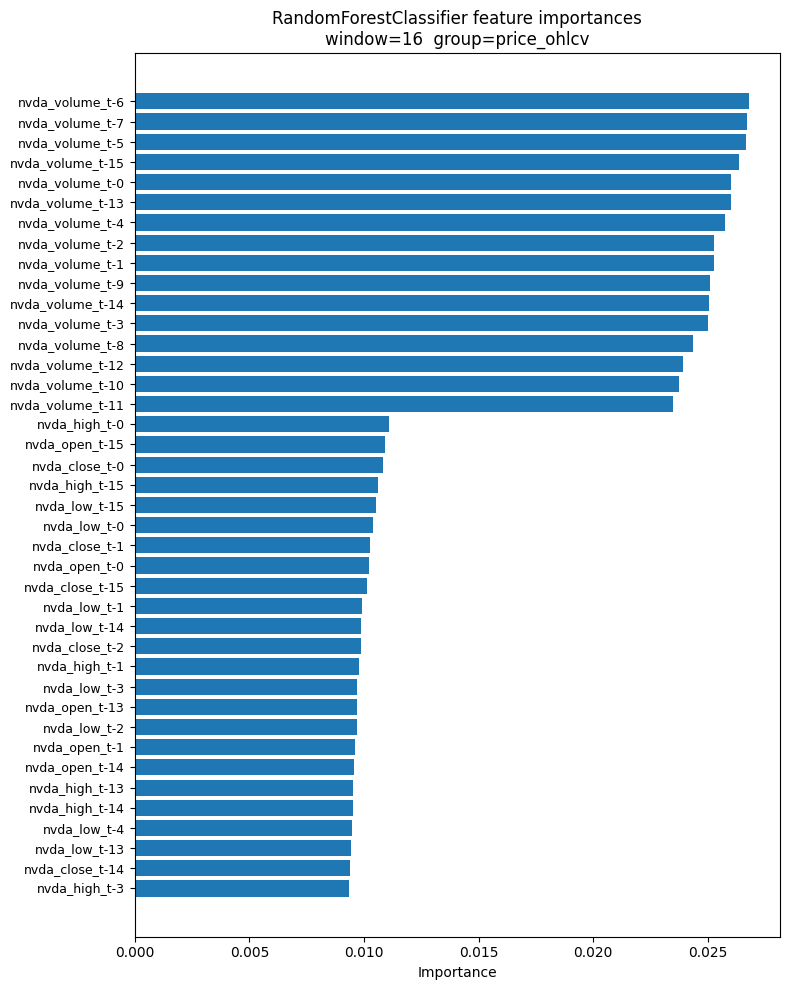

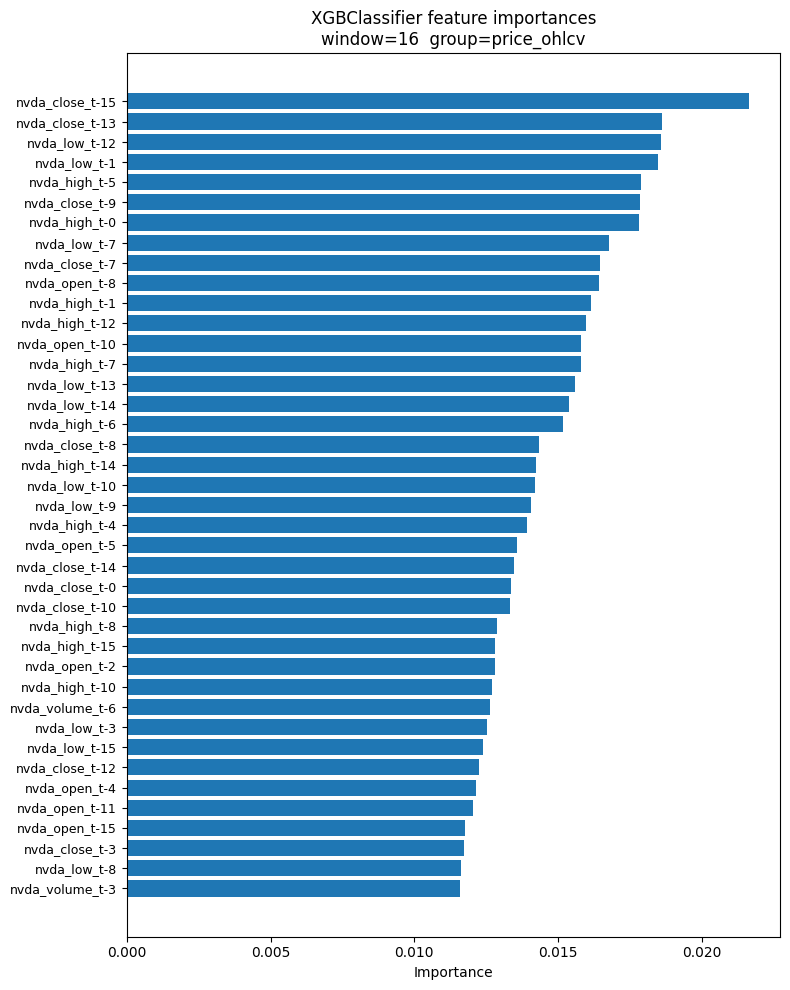

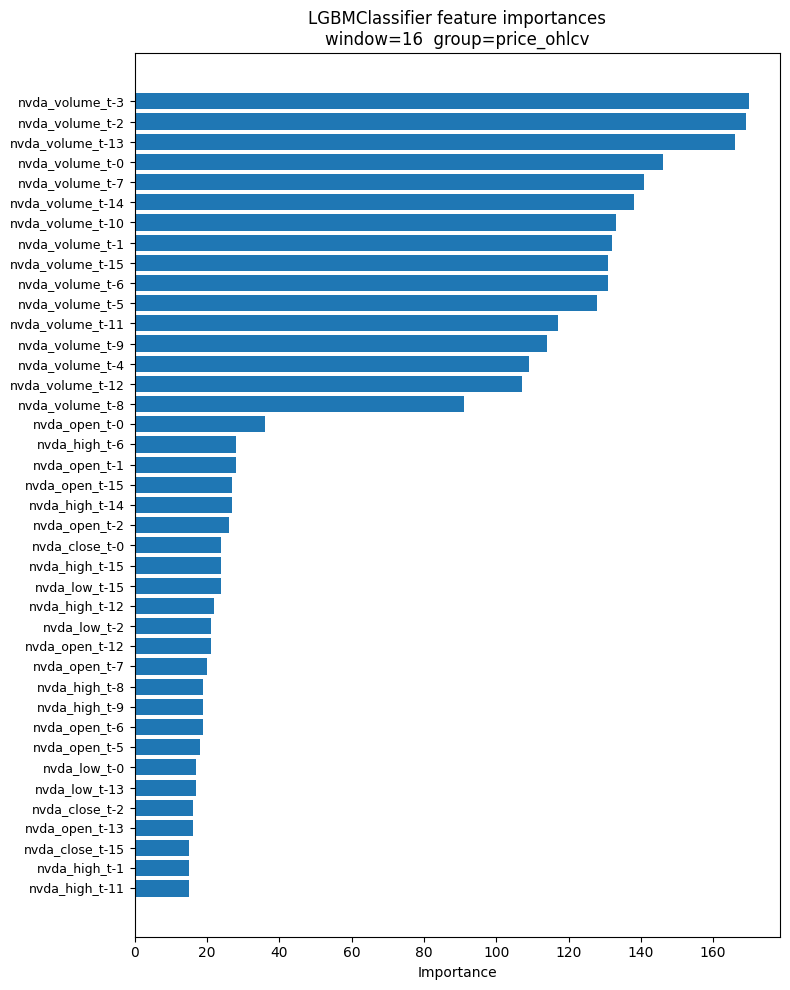

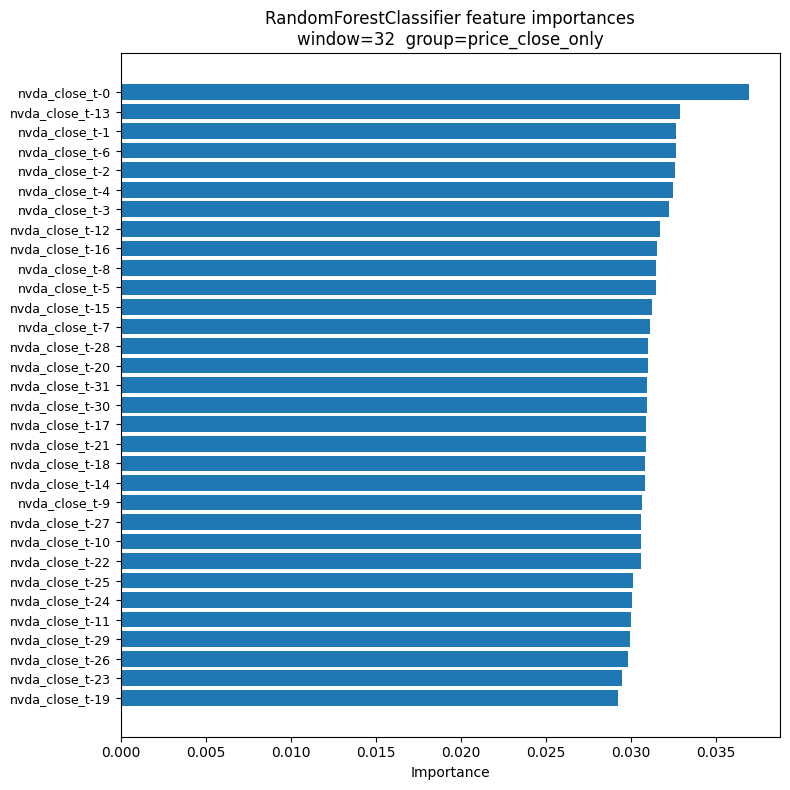

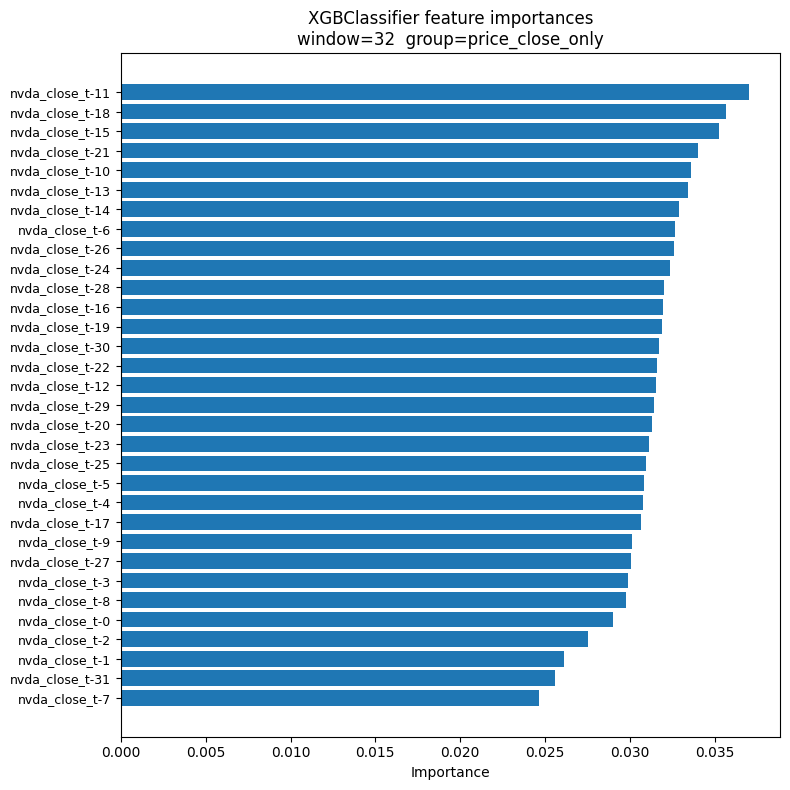

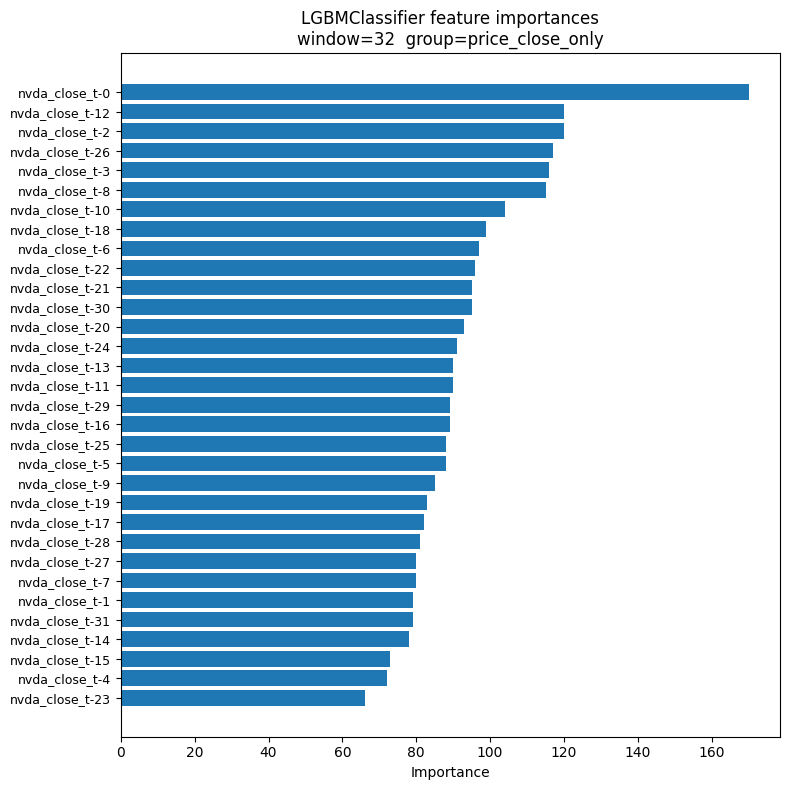

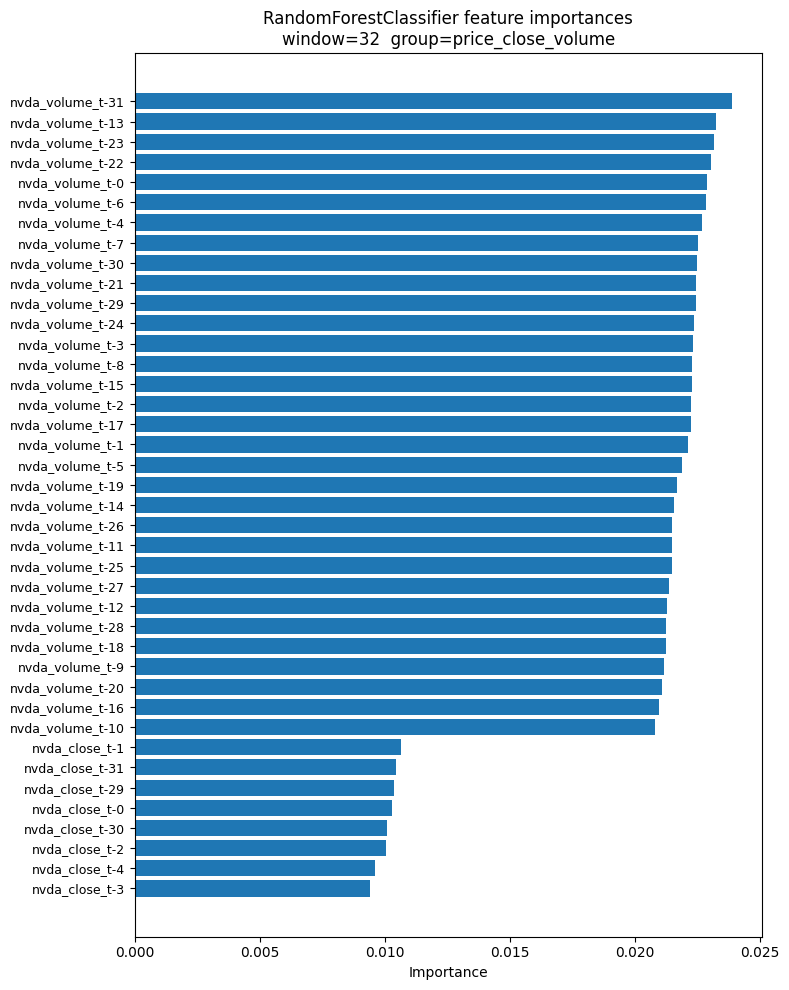

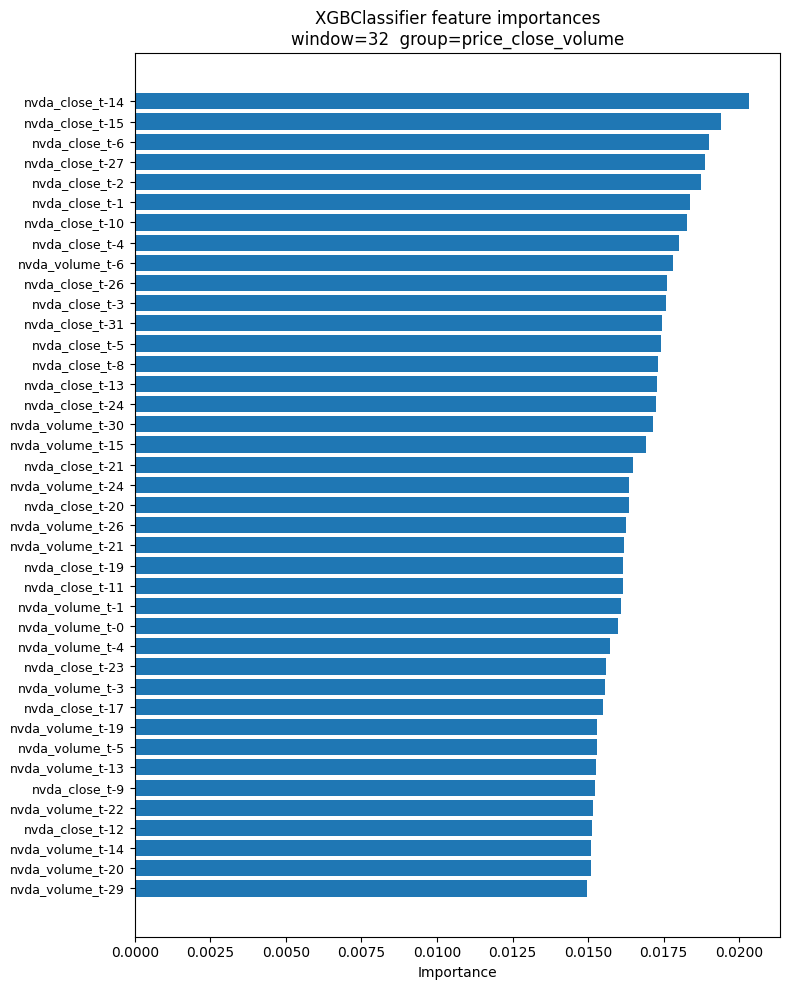

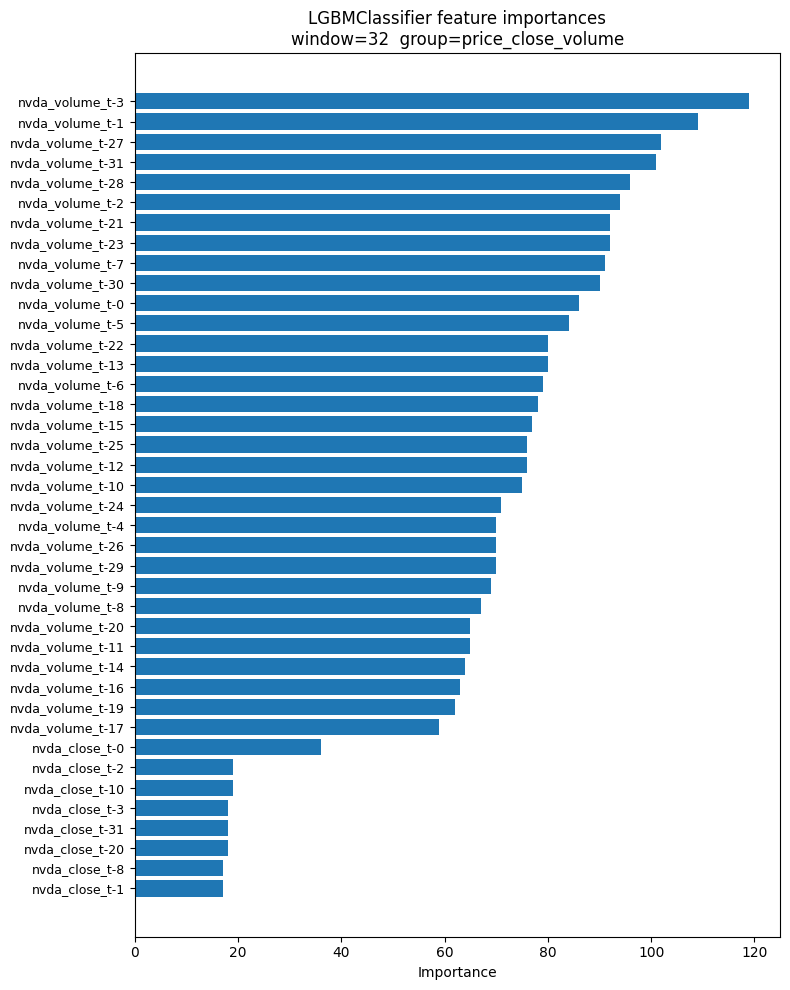

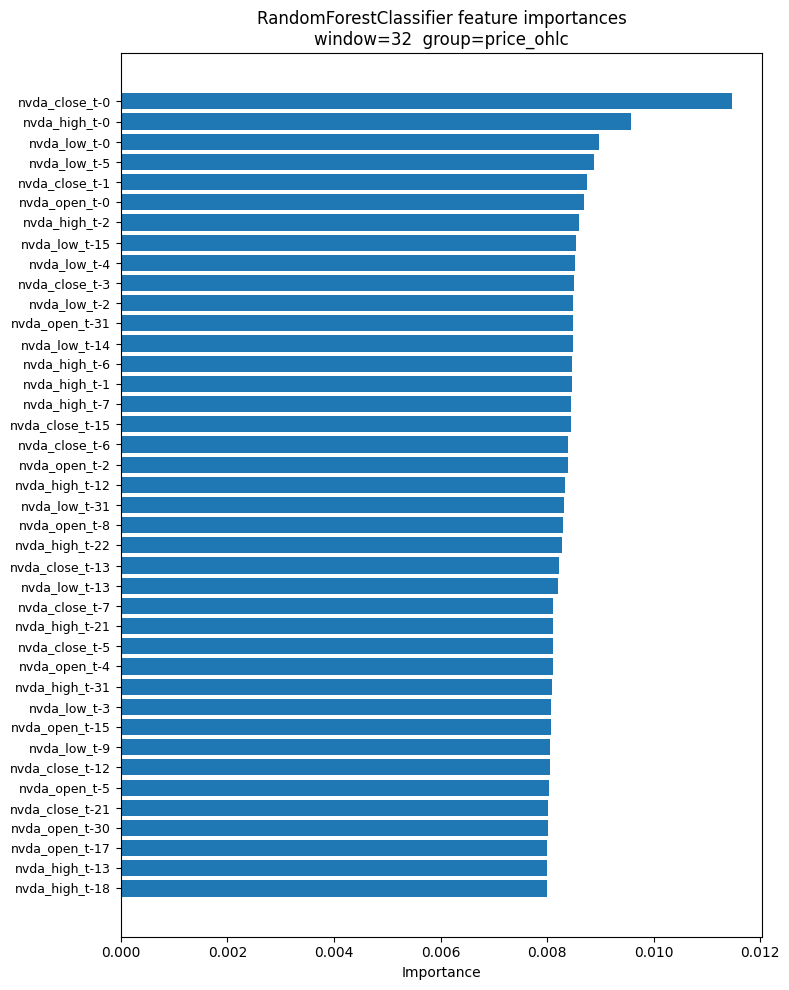

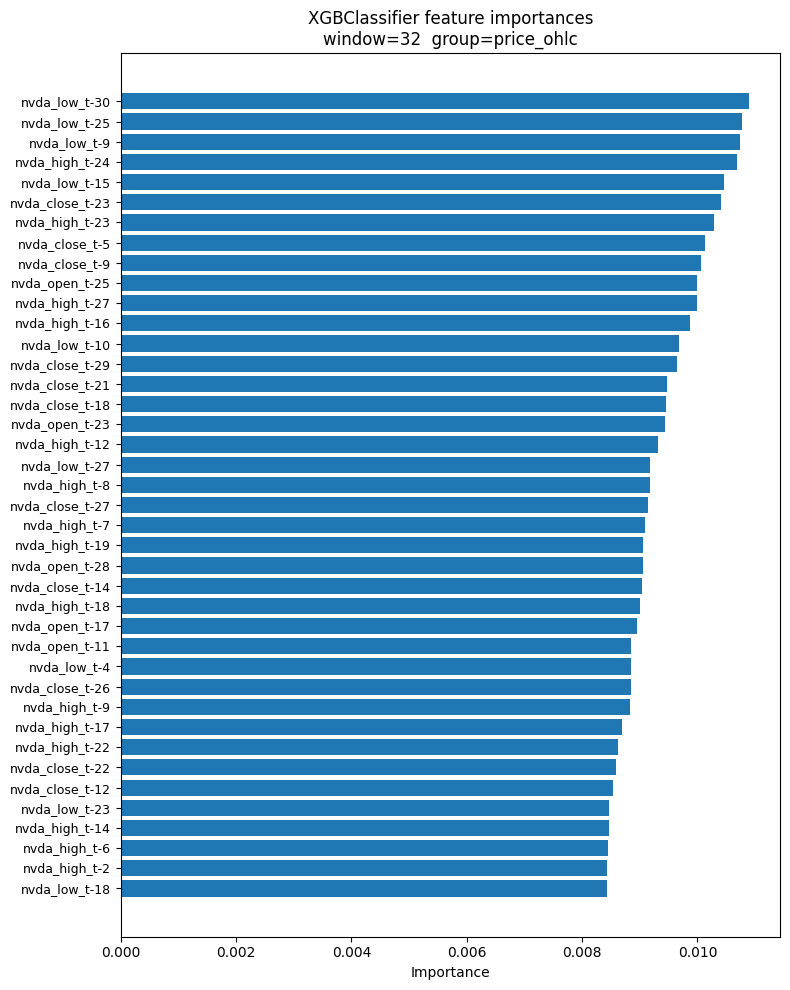

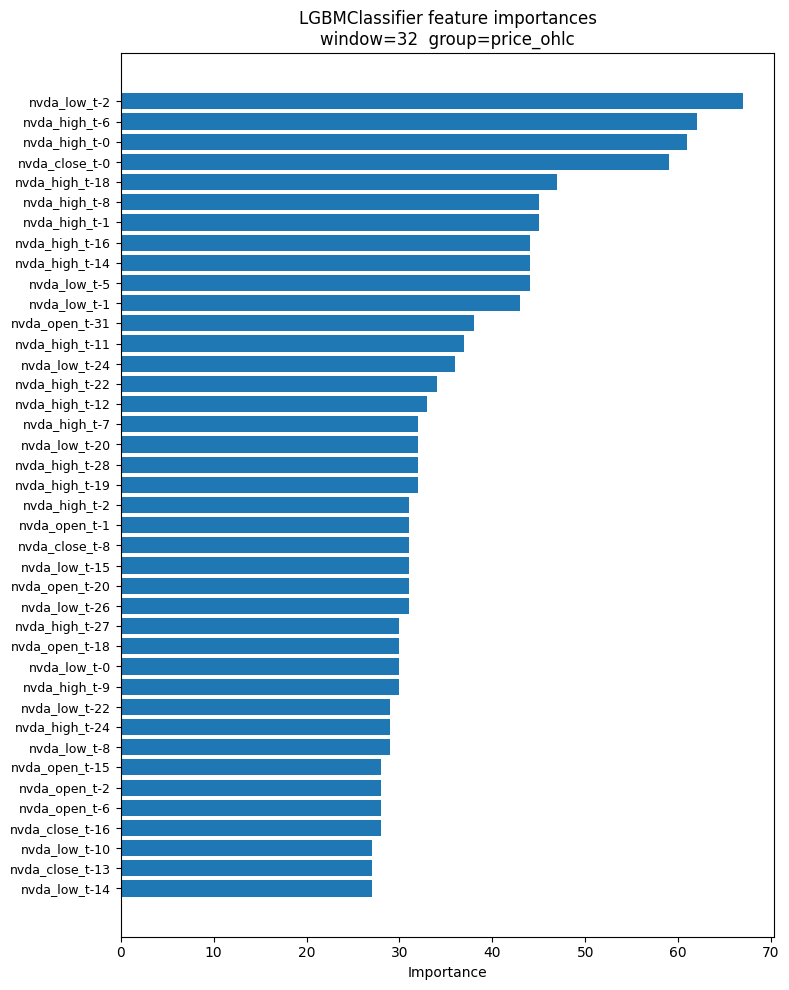

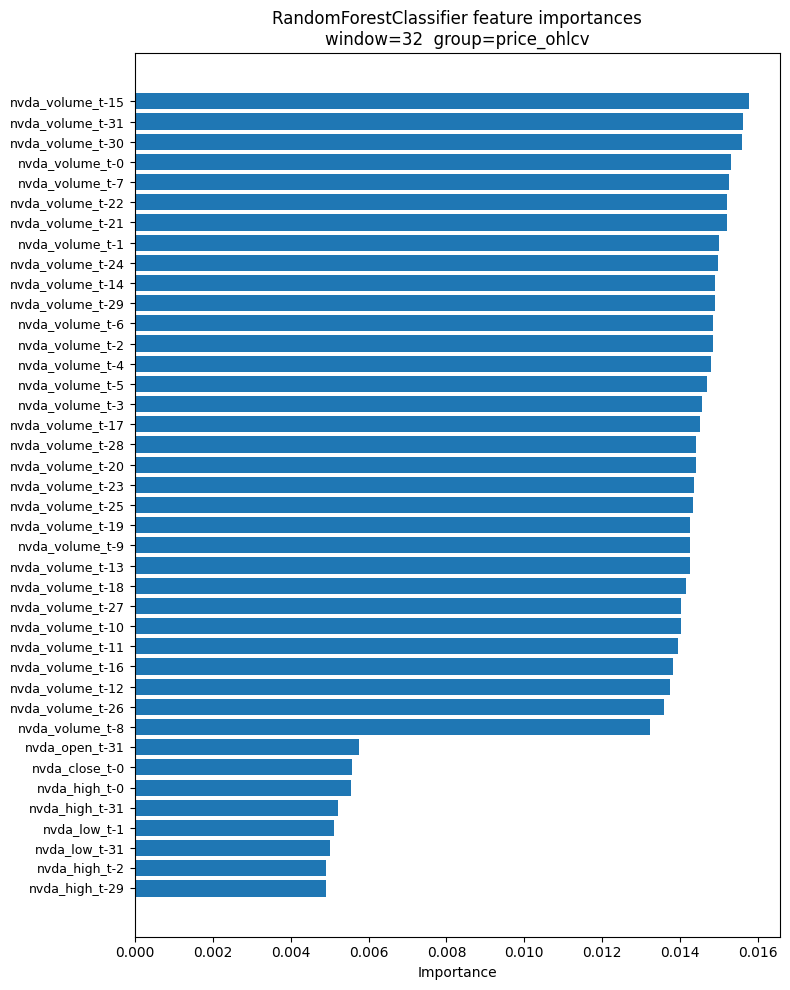

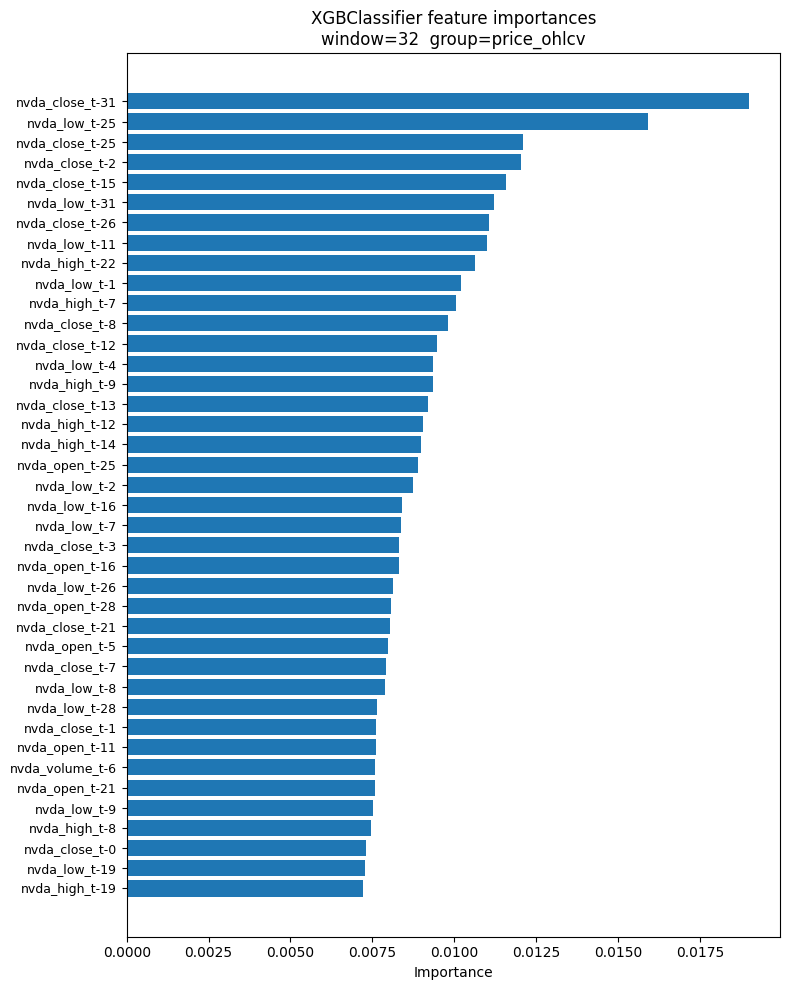

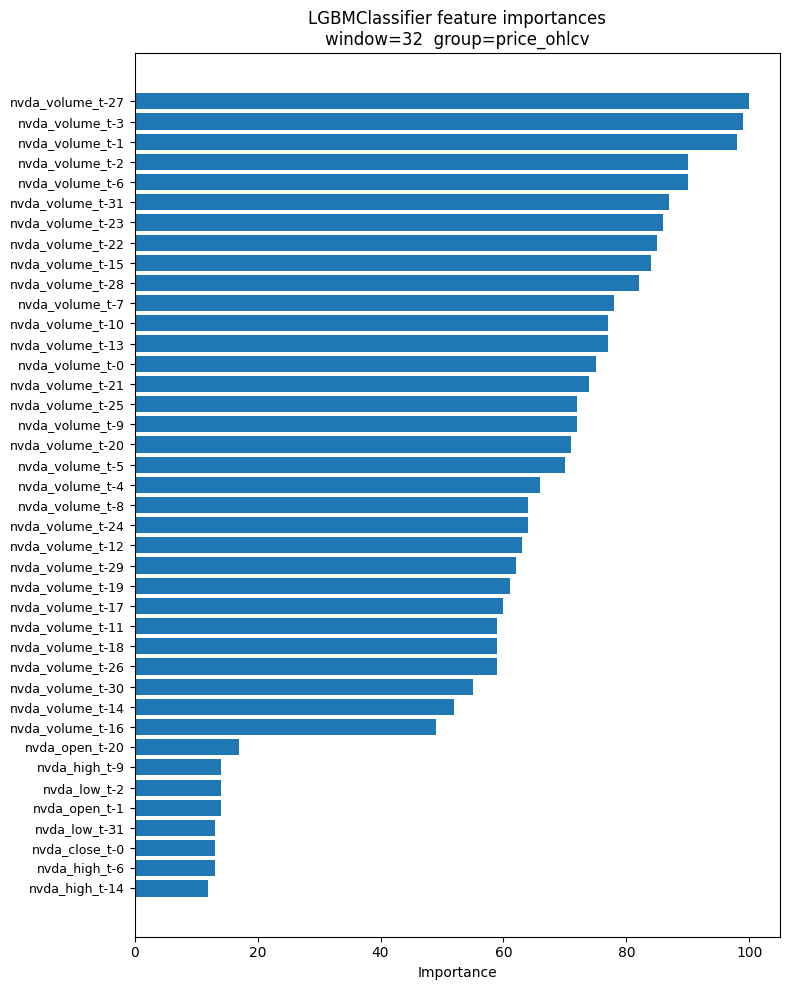

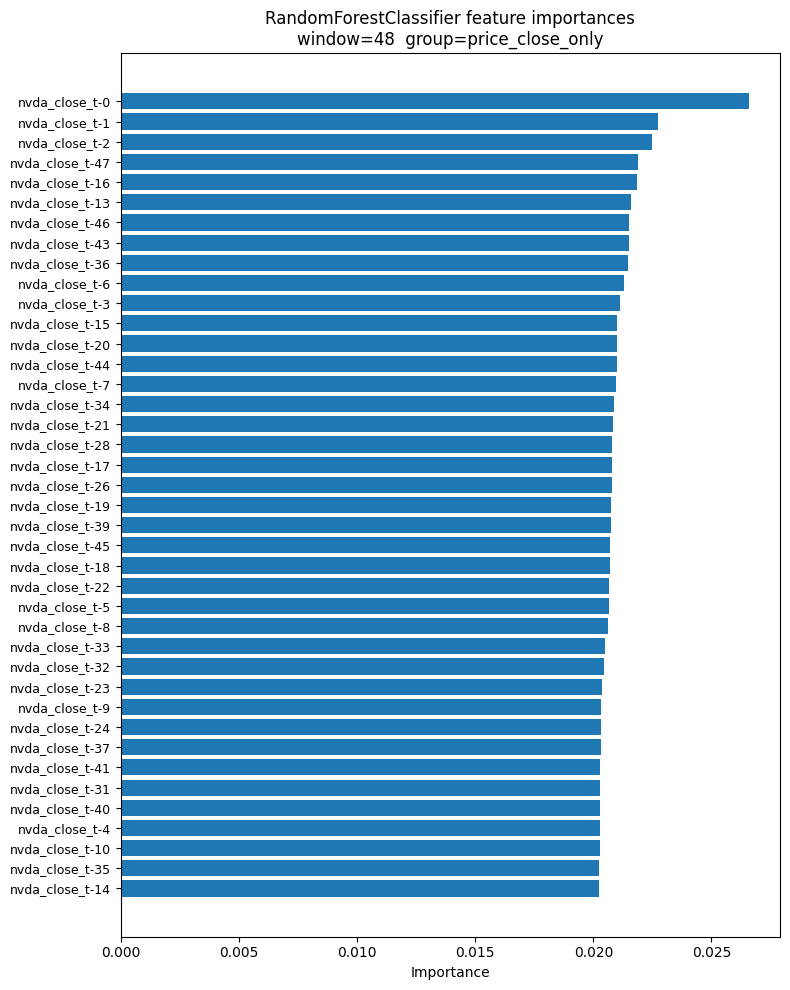

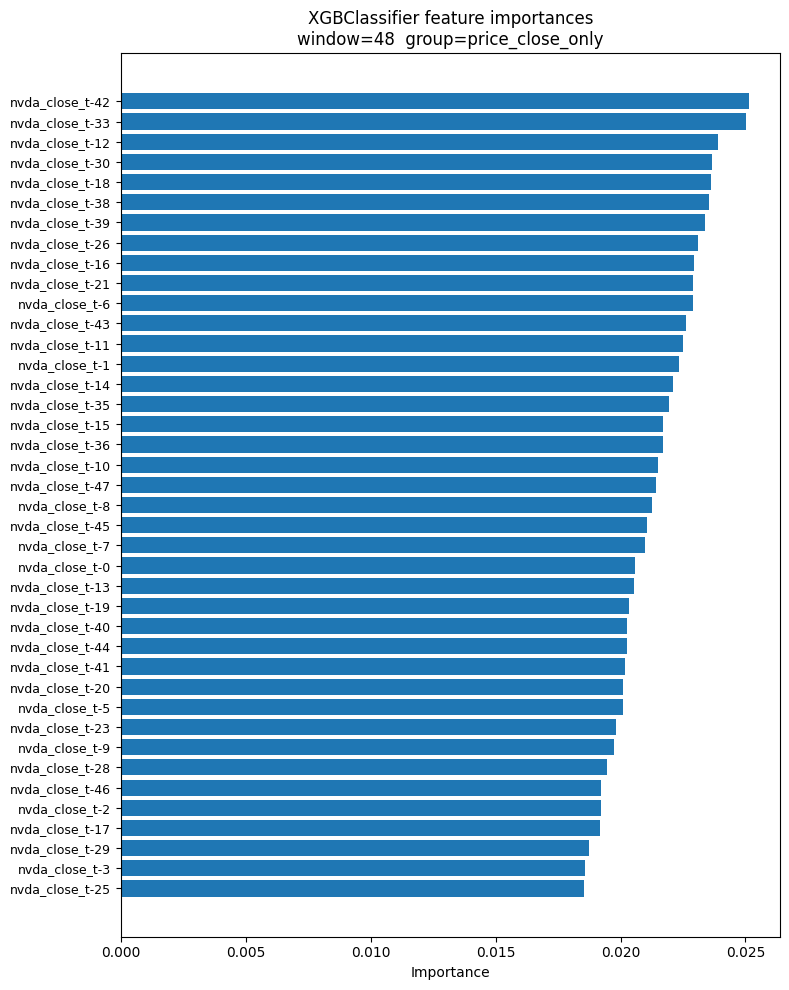

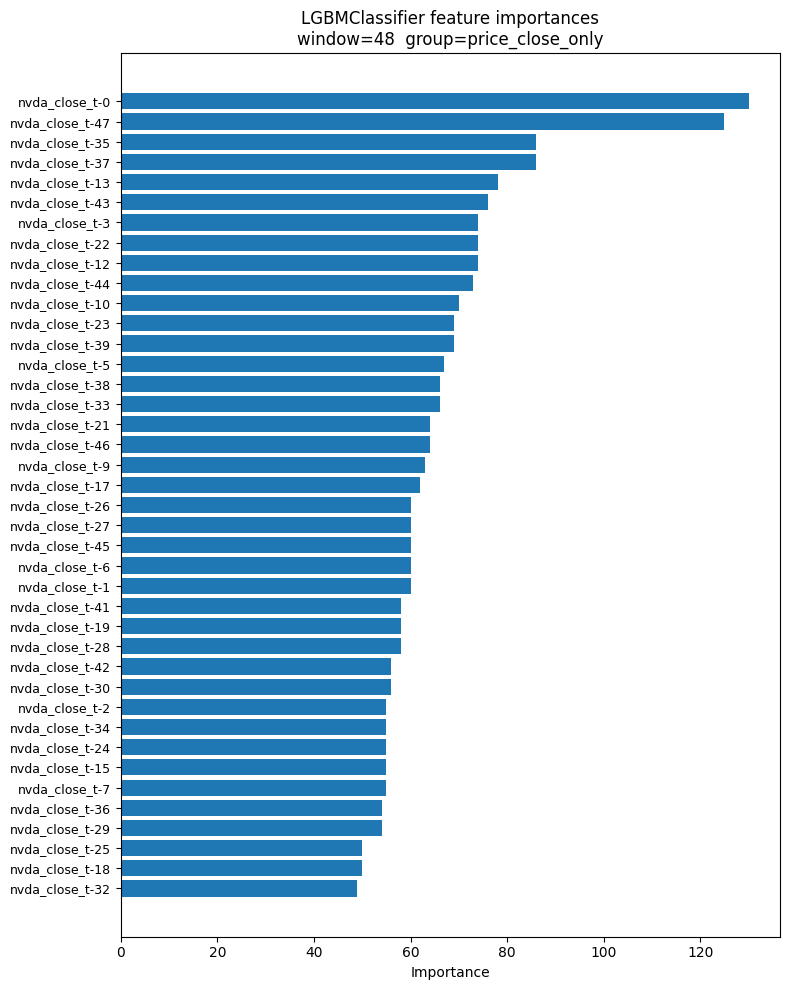

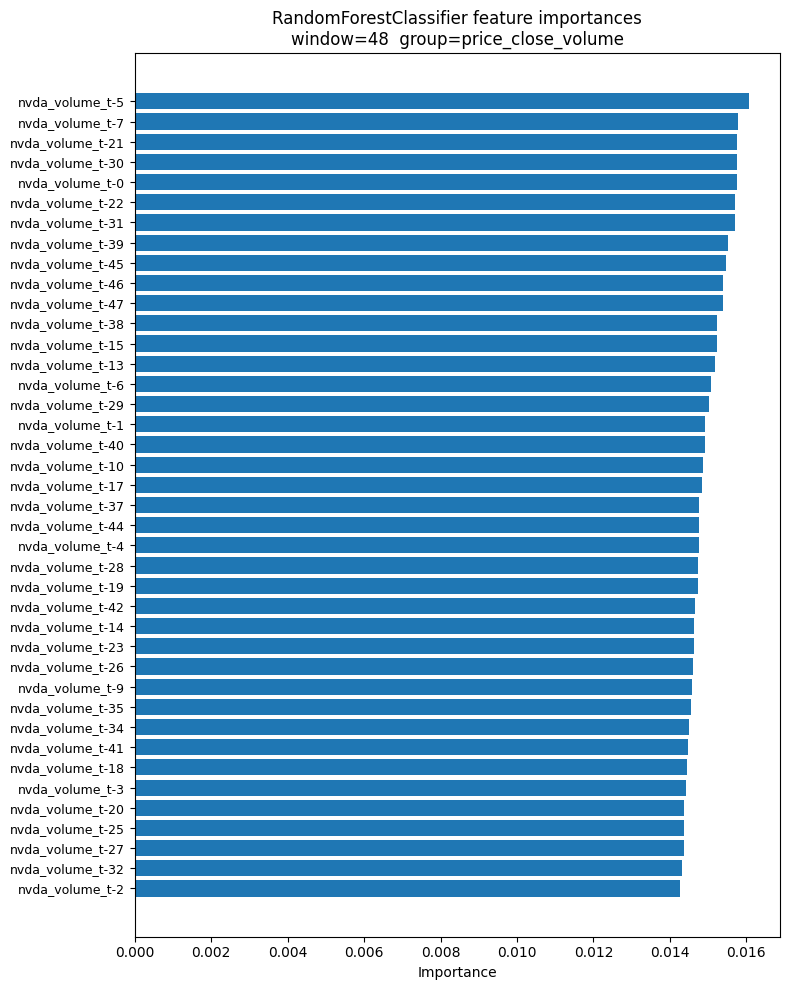

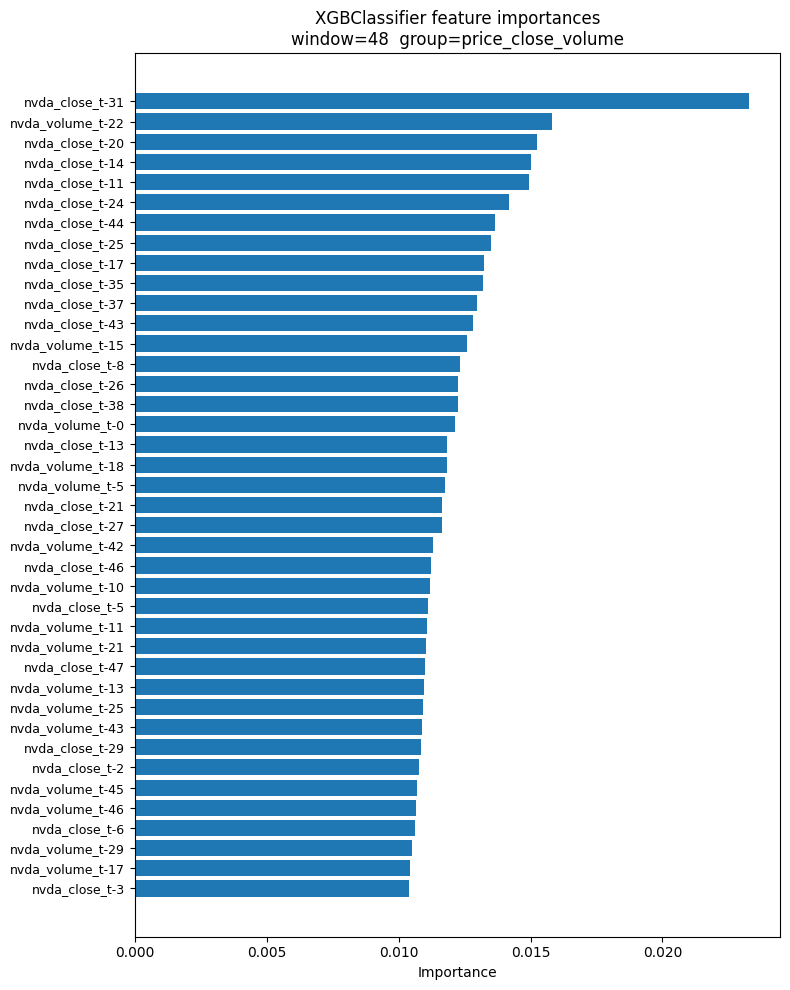

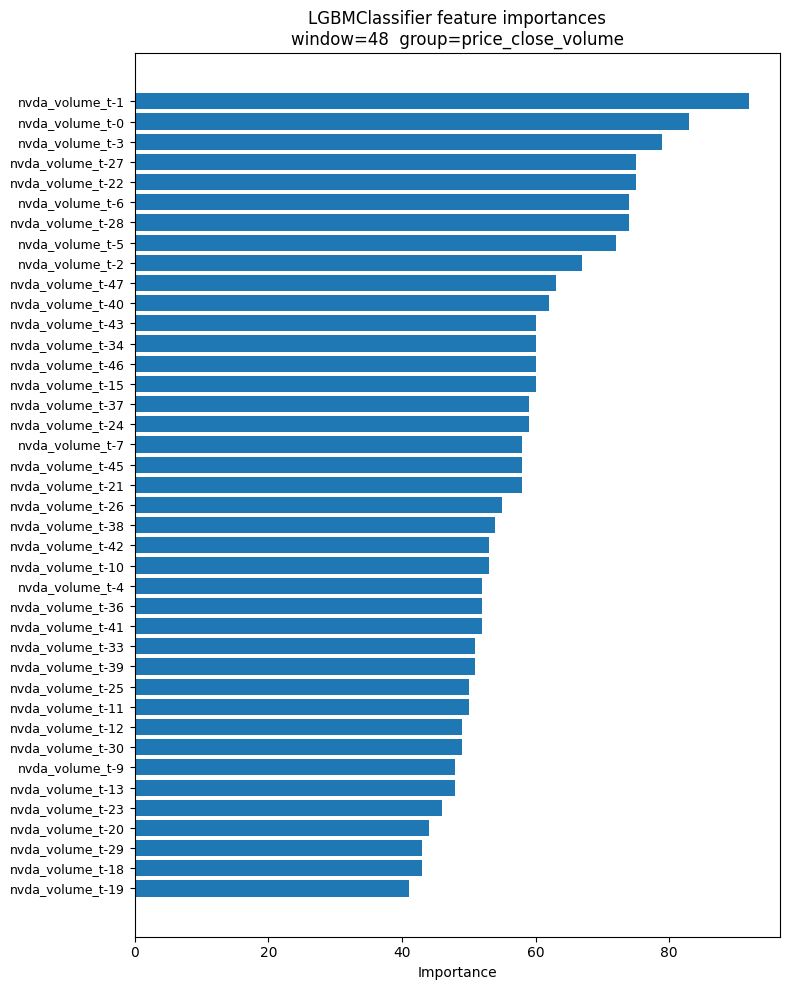

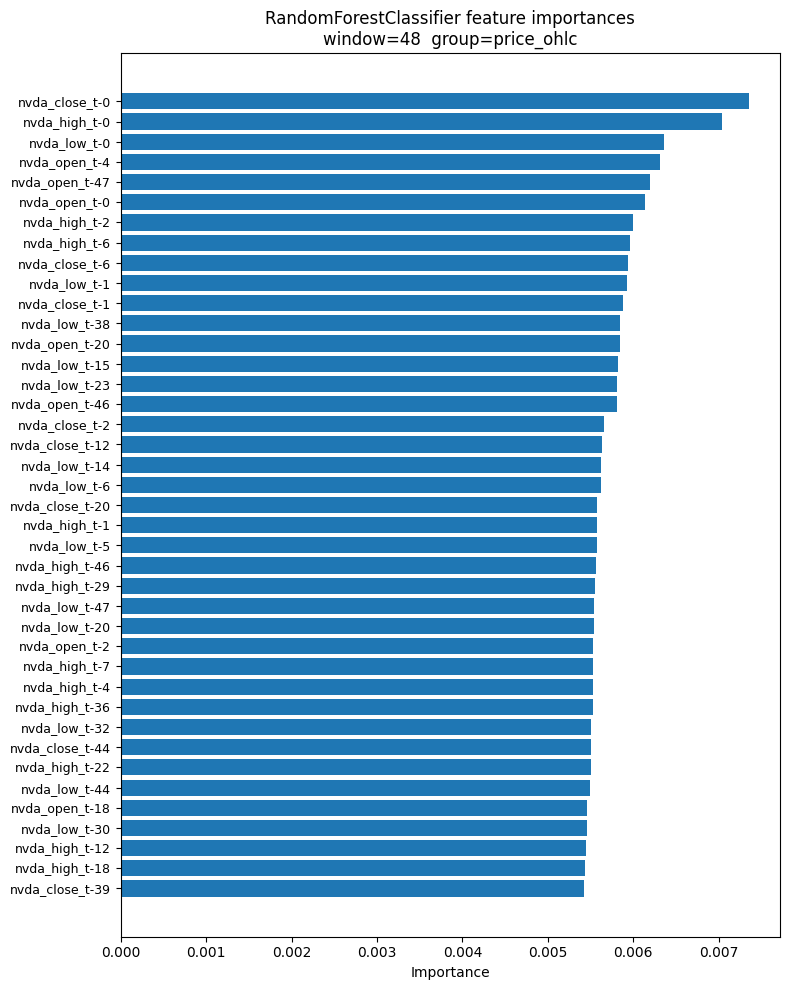

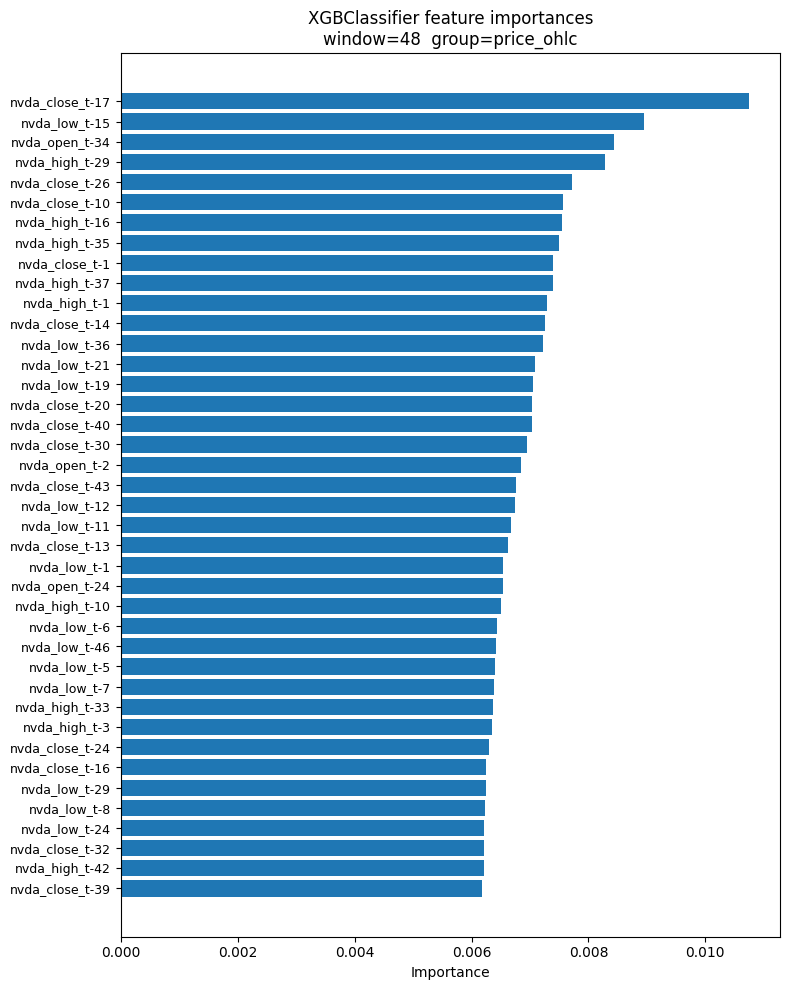

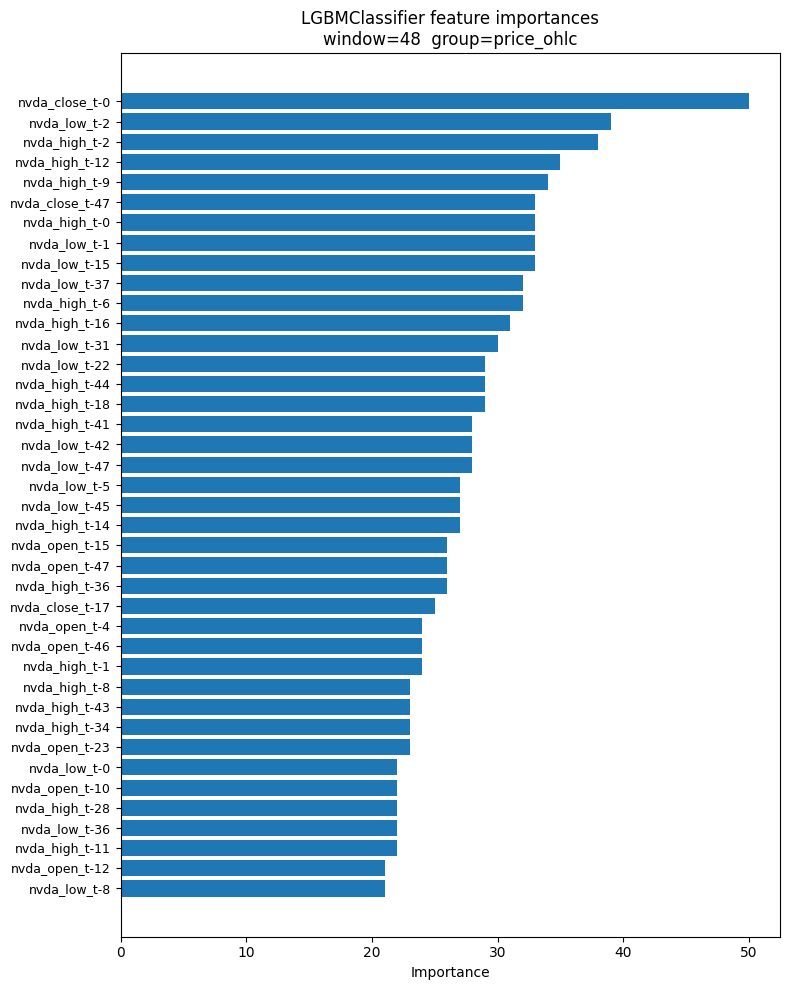

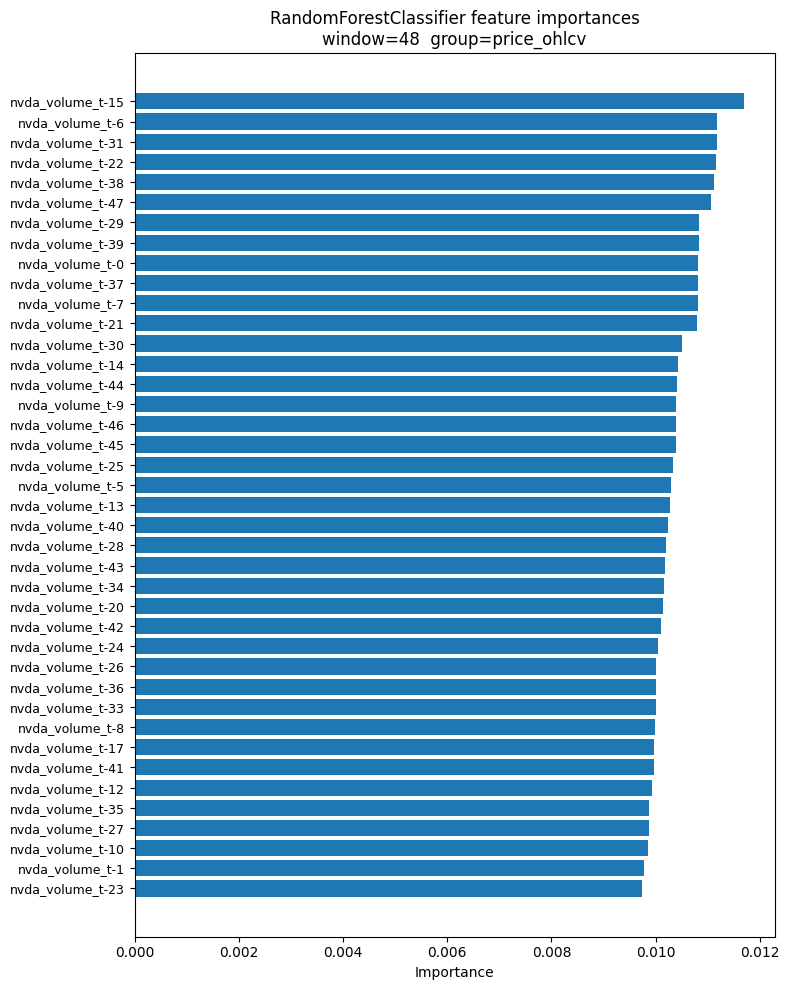

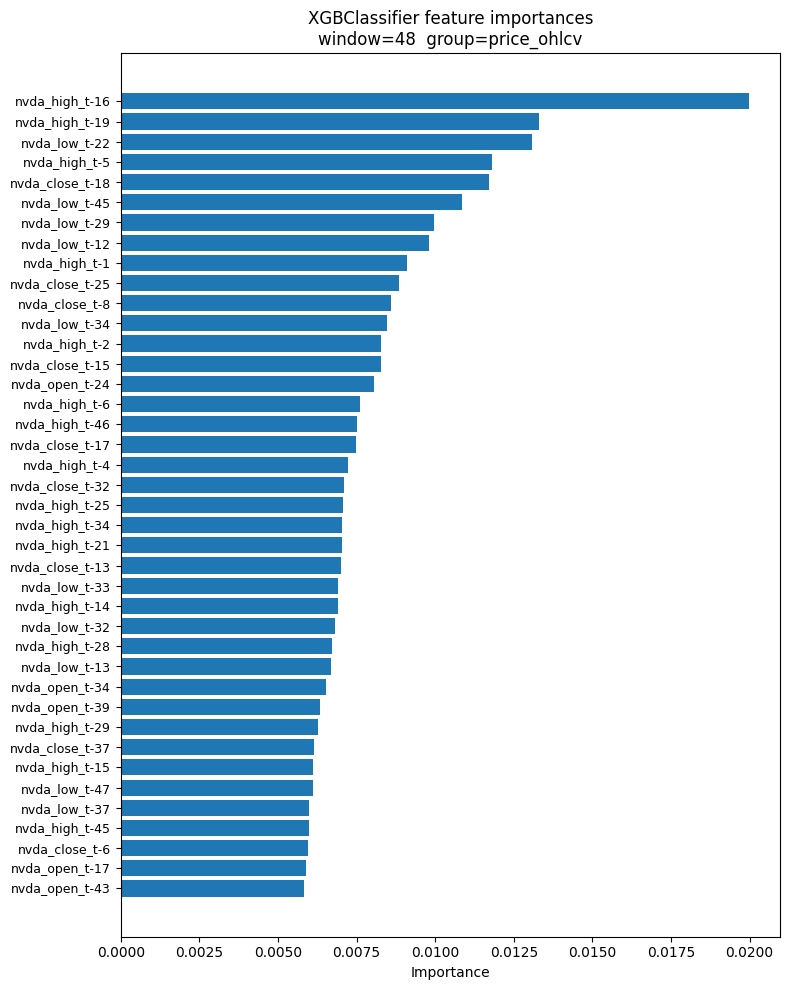

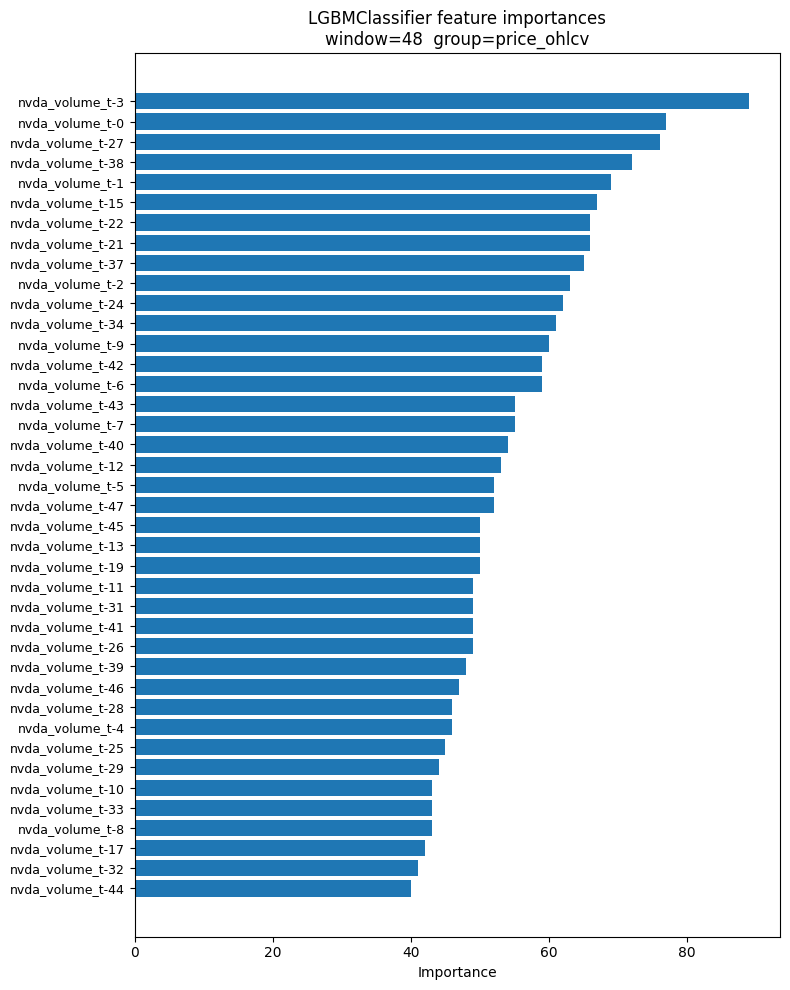

In [70]:
import os

# Plot feature importances for RF, XGB, LGBM from loaded pipelines
TARGET_MODELS = {"RandomForestClassifier", "XGBClassifier", "LGBMClassifier"}
TOP_N = 40
out_dir = "models/feature_importances"
os.makedirs(out_dir, exist_ok=True)

for (window_size, col_group_name, model_name), pipeline in pipelines_loaded.items():
    if model_name not in TARGET_MODELS:
        continue

    # build feature names the same way as training
    base_cols = COLS_GROUPS.get(col_group_name)
    feature_names = generate_column_names(base_cols, window_size)

    # get classifier from pipeline
    try:
        clf = pipeline.named_steps["classifier"]
    except Exception:
        # fallback if pipeline object structure differs
        clf = pipeline.steps[-1][1] if hasattr(pipeline, "steps") else pipeline

    # extract importances
    importances = None
    if hasattr(clf, "feature_importances_"):
        importances = np.array(clf.feature_importances_, dtype=float)
    elif hasattr(clf, "coef_"):
        # linear models provide coef_ (may be multi-dim for multiclass)
        coef = np.array(clf.coef_)
        if coef.ndim > 1:
            # take absolute mean across classes
            importances = np.mean(np.abs(coef), axis=0)
        else:
            importances = np.abs(coef)
    elif model_name == "XGBClassifier" and hasattr(clf, "get_booster"):
        # xgboost booster fallback
        try:
            booster = clf.get_booster()
            score = booster.get_score(importance_type="gain")
            # mapping feature indices to names (xgboost uses f0, f1, ...)
            importances = np.zeros(len(feature_names), dtype=float)
            for k, v in score.items():
                if k.startswith("f"):
                    idx = int(k[1:])
                    if idx < len(importances):
                        importances[idx] = v
        except Exception:
            importances = None

    if importances is None:
        print(f"Skipping {model_name} | window={window_size} | group={col_group_name}: no importances available")
        continue

    if len(importances) != len(feature_names):
        # try to align by trimming or padding
        L = min(len(importances), len(feature_names))
        importances = importances[:L]
        feature_names = feature_names[:L]

    # skip if all zero
    if np.all(importances == 0):
        print(f"All importances zero for {model_name} | window={window_size} | group={col_group_name}, skipping plot.")
        continue

    # top features
    idx_sorted = np.argsort(importances)[::-1][:TOP_N]
    top_feats = [feature_names[i] for i in idx_sorted]
    top_vals = importances[idx_sorted]

    plt.figure(figsize=(8, max(4, 0.25 * len(top_feats))))
    y_pos = np.arange(len(top_feats))
    plt.barh(y_pos, top_vals[::-1], align="center")
    plt.yticks(y_pos, top_feats[::-1], fontsize=9)
    plt.xlabel("Importance")
    plt.title(f"{model_name} feature importances\nwindow={window_size}  group={col_group_name}")
    plt.tight_layout()

    # fname = os.path.join(out_dir, f"fi_w{window_size}_{col_group_name}_{model_name}.png")
    # plt.savefig(fname, dpi=150)
    plt.show()
    plt.close()

    # print(f"Saved: {fname}")

In [69]:
y_pred_16 = pipelines[(16, "price_close_volume", "LGBMClassifier")].predict(
    X_test_16[generate_column_names(PRICE_CLOSE_VOLUME_COLS, 16)]
)
print(classification_report(y_test_16, y_pred_16, target_names=["Down", "Up"], zero_division=0))

              precision    recall  f1-score   support

        Down       0.56      0.74      0.64      1083
          Up       0.50      0.31      0.38       914

    accuracy                           0.54      1997
   macro avg       0.53      0.52      0.51      1997
weighted avg       0.53      0.54      0.52      1997



In [ ]:
X_train_16[generate_column_names(PRICE_CLOSE_VOLUME_COLS, 16)]

,nvda_close_t-0,nvda_volume_t-0,nvda_close_t-1,nvda_volume_t-1,nvda_close_t-2,nvda_volume_t-2,nvda_close_t-3,nvda_volume_t-3,nvda_close_t-4,nvda_volume_t-4,...,nvda_close_t-11,nvda_volume_t-11,nvda_close_t-12,nvda_volume_t-12,nvda_close_t-13,nvda_volume_t-13,nvda_close_t-14,nvda_volume_t-14,nvda_close_t-15,nvda_volume_t-15
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-04 00:00:00+00:00,23.980354,23.803928,23.985493,23.817598,23.988072,23.821219,23.990977,23.826207,23.993942,23.831522,...,24.009855,23.851192,24.007261,23.834180,24.006757,23.825069,24.007231,23.819578,24.007710,23.813862
2022-03-04 09:00:00+00:00,23.972896,23.781452,23.980354,23.803928,23.985493,23.817598,23.988072,23.821219,23.990977,23.826207,...,24.010119,23.858455,24.009855,23.851192,24.007261,23.834180,24.006757,23.825069,24.007231,23.819578
2022-03-04 10:00:00+00:00,23.966108,23.762207,23.972896,23.781452,23.980354,23.803928,23.985493,23.817598,23.988072,23.821219,...,24.005066,23.844488,24.010119,23.858455,24.009855,23.851192,24.007261,23.834180,24.006757,23.825069
2022-03-04 11:00:00+00:00,23.959317,23.743442,23.966108,23.762207,23.972896,23.781452,23.980354,23.803928,23.985493,23.817598,...,24.004047,23.846767,24.005066,23.844488,24.010119,23.858455,24.009855,23.851192,24.007261,23.834180
2022-03-04 12:00:00+00:00,23.951770,23.722162,23.959317,23.743442,23.966108,23.762207,23.972896,23.781452,23.980354,23.803928,...,24.002788,23.847973,24.004047,23.846767,24.005066,23.844488,24.010119,23.858455,24.009855,23.851192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 14:00:00+00:00,74.708420,78.127546,74.660881,78.074033,74.620828,78.050684,74.583349,78.038467,74.545493,78.025751,...,74.321484,78.145678,74.283311,78.146738,74.242664,78.139352,74.201493,78.131195,74.156894,78.110464
2024-02-29 15:00:00+00:00,74.754162,78.173740,74.708420,78.127546,74.660881,78.074033,74.620828,78.050684,74.583349,78.038467,...,74.354510,78.125871,74.321484,78.145678,74.283311,78.146738,74.242664,78.139352,74.201493,78.131195
2024-02-29 16:00:00+00:00,74.795966,78.204393,74.754162,78.173740,74.708420,78.127546,74.660881,78.074033,74.620828,78.050684,...,74.382344,78.087672,74.354510,78.125871,74.321484,78.145678,74.283311,78.146738,74.242664,78.139352


In [ ]:
y_prob = model.predict_proba(X_val_scaled)[:, 1]

Best threshold: 0.6374
Accuracy at best threshold: 0.5491
Accuracy (best threshold): 0.5491
Confusion Matrix:
 [[965 110]
 [786 126]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      0.90      0.68      1075
         1.0       0.53      0.14      0.22       912

    accuracy                           0.55      1987
   macro avg       0.54      0.52      0.45      1987
weighted avg       0.54      0.55      0.47      1987

Accuracy (best threshold): 0.5310
Confusion Matrix:
 [[824 251]
 [681 231]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      0.77      0.64      1075
         1.0       0.48      0.25      0.33       912

    accuracy                           0.53      1987
   macro avg       0.51      0.51      0.49      1987
weighted avg       0.52      0.53      0.50      1987



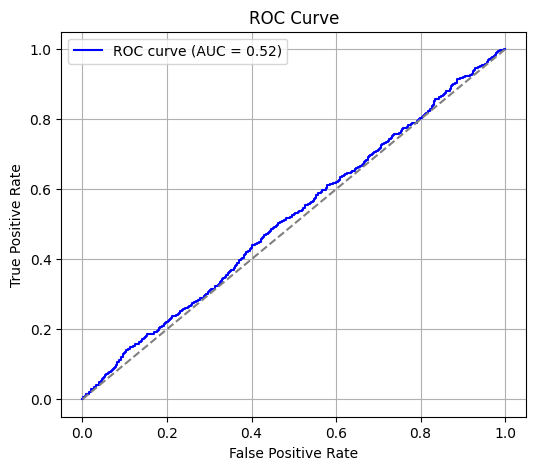

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

# --- Find best threshold for max accuracy ---
best_acc = 0
best_thresh = 0.5
for thresh in thresholds:
    y_pred_custom = (y_prob >= thresh).astype(int)
    acc = accuracy_score(y_val, y_pred_custom)
    if acc > best_acc:
        best_acc = acc
        best_thresh = thresh

print(f"Best threshold: {best_thresh:.4f}")
print(f"Accuracy at best threshold: {best_acc:.4f}")

y_pred_best = (y_prob >= best_thresh).astype(int)

# Evaluate
acc = accuracy_score(y_val, y_pred_best)
cm = confusion_matrix(y_val, y_pred_best)
report = classification_report(y_val, y_pred_best)

print(f"Accuracy (best threshold): {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

y_pred = (y_prob >= 0.5).astype(int)

# Evaluate
acc = accuracy_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"Accuracy (best threshold): {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)


# --- Plot ROC curve ---
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

Accuracy (best threshold): 0.5476
Confusion Matrix:
 [[773 306]
 [593 315]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.57      0.72      0.63      1079
         1.0       0.51      0.35      0.41       908

    accuracy                           0.55      1987
   macro avg       0.54      0.53      0.52      1987
weighted avg       0.54      0.55      0.53      1987

Accuracy (best threshold): 0.5471
Confusion Matrix:
 [[631 448]
 [452 456]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.58      0.58      0.58      1079
         1.0       0.50      0.50      0.50       908

    accuracy                           0.55      1987
   macro avg       0.54      0.54      0.54      1987
weighted avg       0.55      0.55      0.55      1987



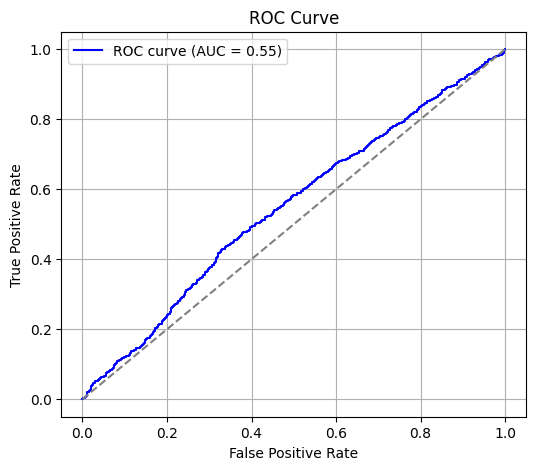

In [ ]:
y_prob = model.predict_proba(X_test_scaled)[:, 1]

y_pred_best = (y_prob >= 0.6374).astype(int)

# Evaluate
acc = accuracy_score(y_test, y_pred_best)
cm = confusion_matrix(y_test, y_pred_best)
report = classification_report(y_test, y_pred_best)

print(f"Accuracy (best threshold): {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

y_pred = (y_prob >= 0.5).astype(int)

# Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy (best threshold): {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)


# --- Plot ROC curve ---
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# --- Predict probabilities ---


Best threshold: 0.5750
Accuracy at best threshold: 0.5415
Accuracy (best threshold): 0.5415
Confusion Matrix:
 [[1045   30]
 [ 881   31]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.54      0.97      0.70      1075
         1.0       0.51      0.03      0.06       912

    accuracy                           0.54      1987
   macro avg       0.53      0.50      0.38      1987
weighted avg       0.53      0.54      0.41      1987

Accuracy (best threshold): 0.4836
Confusion Matrix:
 [[461 614]
 [412 500]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.53      0.43      0.47      1075
         1.0       0.45      0.55      0.49       912

    accuracy                           0.48      1987
   macro avg       0.49      0.49      0.48      1987
weighted avg       0.49      0.48      0.48      1987



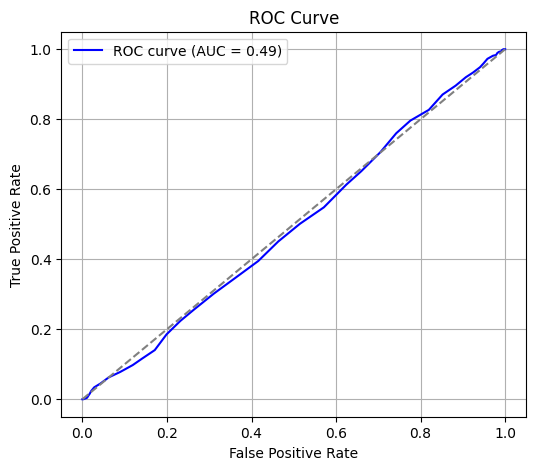

In [ ]:
y_prob = rf_model.predict_proba(X_val_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

# --- Find best threshold for max accuracy ---
best_acc = 0
best_thresh = 0.5
for thresh in thresholds:
    y_pred_custom = (y_prob >= thresh).astype(int)
    acc = accuracy_score(y_val, y_pred_custom)
    if acc > best_acc:
        best_acc = acc
        best_thresh = thresh

print(f"Best threshold: {best_thresh:.4f}")
print(f"Accuracy at best threshold: {best_acc:.4f}")

y_pred_best = (y_prob >= best_thresh).astype(int)

# Evaluate
acc = accuracy_score(y_val, y_pred_best)
cm = confusion_matrix(y_val, y_pred_best)
report = classification_report(y_val, y_pred_best)

print(f"Accuracy (best threshold): {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

y_pred = (y_prob >= 0.5).astype(int)

# Evaluate
acc = accuracy_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"Accuracy (best threshold): {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)


# --- Plot ROC curve ---
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

Accuracy (best threshold): 0.5576
Confusion Matrix:
 [[716 363]
 [516 392]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.58      0.66      0.62      1079
         1.0       0.52      0.43      0.47       908

    accuracy                           0.56      1987
   macro avg       0.55      0.55      0.55      1987
weighted avg       0.55      0.56      0.55      1987

Accuracy (best threshold): 0.5471
Confusion Matrix:
 [[631 448]
 [452 456]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.58      0.58      0.58      1079
         1.0       0.50      0.50      0.50       908

    accuracy                           0.55      1987
   macro avg       0.54      0.54      0.54      1987
weighted avg       0.55      0.55      0.55      1987



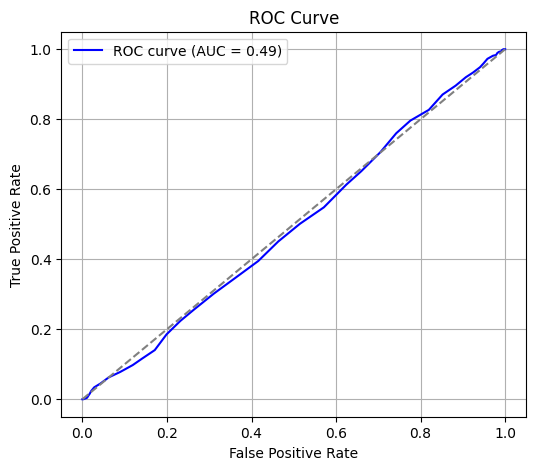

In [ ]:
# y_prob = model.predict_proba(X_test_scaled)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# roc_auc = auc(fpr, tpr)

# # --- Find best threshold for max accuracy ---
# best_acc = 0
# best_thresh = 0.5
# for thresh in thresholds:
#     y_pred_custom = (y_prob >= thresh).astype(int)
#     acc = accuracy_score(y_test, y_pred_custom)
#     if acc > best_acc:
#         best_acc = acc
#         best_thresh = thresh

# print(f"Best threshold: {best_thresh:.4f}")
# print(f"Accuracy at best threshold: {best_acc:.4f}")
y_prob = model.predict_proba(X_test_scaled)[:, 1]

y_pred_best = (y_prob >= 0.5750).astype(int)

# Evaluate
acc = accuracy_score(y_test, y_pred_best)
cm = confusion_matrix(y_test, y_pred_best)
report = classification_report(y_test, y_pred_best)

print(f"Accuracy (best threshold): {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

y_pred = (y_prob >= 0.5).astype(int)

# Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy (best threshold): {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)


# --- Plot ROC curve ---
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import lightgbm as lgb

In [ ]:
lgb_train = lgb.Dataset(X_train_scaled, y_train)
lgb_eval = lgb.Dataset(X_val_scaled, y_val, reference=lgb_train)
# lgb_eval = lgb.Dataset(X_test_scaled, y_test, reference=lgb_train)

In [ ]:
params = {
    "objective": "binary",  # For binary classification
    "metric": "binary_logloss",  # Evaluation metric
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "verbose": -1,  # Suppress verbose output
}

In [ ]:
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,  # Number of boosting rounds
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(10)],
)  # Early stopping to prevent overfitting

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.685657


In [ ]:
y_prob = gbm.predict(X_val_scaled, num_iteration=gbm.best_iteration)
# y_pred = (y_pred_proba > 0.5).astype(int) # For binary classification

Best threshold: 0.5182
Accuracy at best threshold: 0.5627
Accuracy (best threshold): 0.5627
Confusion Matrix:
 [[920 155]
 [714 198]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.56      0.86      0.68      1075
         1.0       0.56      0.22      0.31       912

    accuracy                           0.56      1987
   macro avg       0.56      0.54      0.50      1987
weighted avg       0.56      0.56      0.51      1987

Accuracy (best threshold): 0.5330
Confusion Matrix:
 [[721 354]
 [574 338]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.56      0.67      0.61      1075
         1.0       0.49      0.37      0.42       912

    accuracy                           0.53      1987
   macro avg       0.52      0.52      0.51      1987
weighted avg       0.53      0.53      0.52      1987



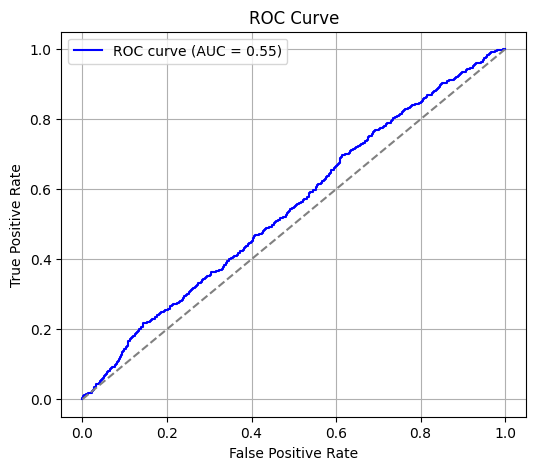

In [ ]:
# y_prob = rf_model.predict_proba(X_val_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

# --- Find best threshold for max accuracy ---
best_acc = 0
best_thresh = 0.5
for thresh in thresholds:
    y_pred_custom = (y_prob >= thresh).astype(int)
    acc = accuracy_score(y_val, y_pred_custom)
    if acc > best_acc:
        best_acc = acc
        best_thresh = thresh

print(f"Best threshold: {best_thresh:.4f}")
print(f"Accuracy at best threshold: {best_acc:.4f}")

y_pred_best = (y_prob >= best_thresh).astype(int)

# Evaluate
acc = accuracy_score(y_val, y_pred_best)
cm = confusion_matrix(y_val, y_pred_best)
report = classification_report(y_val, y_pred_best)

print(f"Accuracy (best threshold): {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

y_pred = (y_prob >= 0.5).astype(int)

# Evaluate
acc = accuracy_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"Accuracy (best threshold): {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)


# --- Plot ROC curve ---
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

Accuracy (best threshold): 0.5471
Confusion Matrix:
 [[812 267]
 [633 275]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.56      0.75      0.64      1079
         1.0       0.51      0.30      0.38       908

    accuracy                           0.55      1987
   macro avg       0.53      0.53      0.51      1987
weighted avg       0.54      0.55      0.52      1987

Accuracy (best threshold): 0.5299
Confusion Matrix:
 [[620 459]
 [475 433]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.57      0.57      0.57      1079
         1.0       0.49      0.48      0.48       908

    accuracy                           0.53      1987
   macro avg       0.53      0.53      0.53      1987
weighted avg       0.53      0.53      0.53      1987



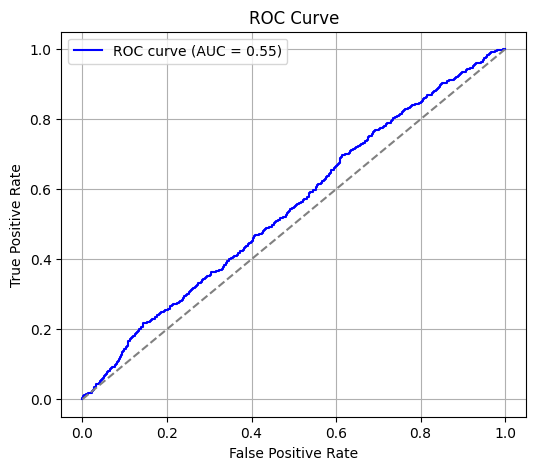

In [ ]:
# y_prob = model.predict_proba(X_test_scaled)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# roc_auc = auc(fpr, tpr)

# # --- Find best threshold for max accuracy ---
# best_acc = 0
# best_thresh = 0.5
# for thresh in thresholds:
#     y_pred_custom = (y_prob >= thresh).astype(int)
#     acc = accuracy_score(y_test, y_pred_custom)
#     if acc > best_acc:
#         best_acc = acc
#         best_thresh = thresh

# print(f"Best threshold: {best_thresh:.4f}")
# print(f"Accuracy at best threshold: {best_acc:.4f}")
y_prob = gbm.predict(X_test_scaled, num_iteration=gbm.best_iteration)

y_pred_best = (y_prob >= 0.5182).astype(int)

# Evaluate
acc = accuracy_score(y_test, y_pred_best)
cm = confusion_matrix(y_test, y_pred_best)
report = classification_report(y_test, y_pred_best)

print(f"Accuracy (best threshold): {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

y_pred = (y_prob >= 0.5).astype(int)

# Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy (best threshold): {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)


# --- Plot ROC curve ---
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()